In [2]:
import os
import numpy as np

from utils.register_dataset import register_vrd_dataset
from config import parse_args, get_vrd_cfg
from utils.trainer import CustomTrainer

### [Optional] Training Visual Backbone Module

In [40]:
#Train Dataset
cfg = get_vrd_cfg()
# register_vrd_dataset('vrd')
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)

[02/14 13:18:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/14 13:18:28 d2.data.build]: Using training sampler TrainingSampler


In [39]:
trainer.resume_or_load(resume=True)
trainer.train()

NameError: name 'trainer' is not defined

In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

detectron = build_model(cfg)

In [ ]:
b = detectron.backbone
b = None
detectron

In [ ]:
detectron.roi_heads.box_pooler

In [ ]:
from detectron2.modeling.poolers import ROIPooler
pooler = ROIPooler((7, 7), pooler_type='ROIAlignV2', scales=[1/4, 1/8, 1/16, 1/32], sampling_ratio=4)
pooler

In [ ]:
#Detections Output
import random
from utils.register_dataset import register_vrd_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

register_vrd_dataset('vrd')
detectron_dataset = DatasetCatalog.get("vrd_train")
vrd_metadata = MetadataCatalog.get("vrd_train")

In [ ]:
%matplotlib inline
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
for d in random.sample(detectron_dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vrd_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.figure(dpi=1200)
    plt.imshow(img)
    plt.show()

In [ ]:
import os
import json
from detectron2.structures import BoxMode
from config import ROOT_DIR, VRD_DATASET_PATH, VG200_DATASET_PATH

def load_dataset_annotations(dataset_name):
    """
        Load raw annotation dataset and convert it into standard detectron2 format
        Input:
            dataset_name: 'vrd/train' or 'vrd/val'
    """
    dataset_dicts = []
    set_name, set_type = dataset_name.split('/')
    if (set_name == 'vrd'):
        
        #VRD data path
        dataset_path = VRD_DATASET_PATH

        #load annotations file
        annotations = {}
        file_name = "new_annotations_{}.json".format(set_type)
        with open(os.path.join(dataset_path, file_name)) as annotations_file:
            annotations = json.load(annotations_file)
        
        #Map 'annotations' to the correct format
        img_file_dir = os.path.join(VRD_DATASET_PATH, '{}_images'.format(set_type))
        for key, val in annotations.items():
            record = {}

            #populating image fields
            img_file_path = os.path.join(img_file_dir, key)
            height, width = cv2.imread(img_file_path).shape[:2]

            record['file_name'] = img_file_path
            record['height'] = height
            record['width'] = width
            record['image_id'] = int(key.split('.')[0])

            #populating annotations from record
            objs = []
            visited = set()
            for anno in val:
                
                subj = anno['subject'] #ymin, ymax, xmin, xmax
                obj = anno['object']
                bbox_subj = subj['bbox']
                bbox_obj = obj['bbox']
                new_bbox_subj = [bbox_subj[2], bbox_subj[0], bbox_subj[3], bbox_subj[1]]
                new_bbox_obj = [bbox_obj[2], bbox_obj[0], bbox_obj[3], bbox_obj[1]]
                
                subj_dict = {
                    'bbox': new_bbox_subj,
                    'bbox_mode': BoxMode.XYXY_ABS,
                    'category_id': subj['category']
                }
                if (tuple(bbox_subj) not in visited):
                    objs.append(subj_dict)
                    visited.add(tuple(bbox_subj))

                obj_dict = {
                    'bbox': new_bbox_obj,
                    'bbox_mode': BoxMode.XYXY_ABS,
                    'category_id': obj['category'],
                }
                if (tuple(bbox_obj) not in visited):
                    objs.append(obj_dict)
                    visited.add(tuple(bbox_obj))

            record['annotations'] = objs
                         
            #add img to dataset dict
            dataset_dicts.append(record)
    
    return dataset_dicts
data = load_dataset_annotations('vrd/train')

### [Required] DataSet and DataLoader (Step 1)

In [3]:
import os
import cv2
import json
import torch
import random
import copy
import numpy as np
from torch._C import import_ir_module
from utils.boxes import boxes_union
from torch.utils.data import Dataset, DataLoader
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt

# from config import ROOT_DIR, VRD_DATASET_PATH, VG200_DATASET_PATH
VRD_DATASET_PATH = "../data/vrd/"

# custom transformation
detectron_transform = T.Resize((800, 800))

class VRDDataset(Dataset):
    def __init__(self, set_type="train", transform=detectron_transform):
        """
            Note:
                transform only applys on bounding boxes. The transformation to the image should be done by detectron2 dataloader.
        """
        annotations_path = os.path.join(
            VRD_DATASET_PATH, "new_annotations_{}.json".format(set_type)
        )
        self.images_dir = os.path.join(VRD_DATASET_PATH, "{}_images".format(set_type))
        self.transform = transform

        with open(annotations_path) as fp:
            raw_annotation = json.load(fp)
        self.annotations = list(raw_annotation.items())

        # check if the data is pre-generated
        roidb_chkpt = os.path.join(VRD_DATASET_PATH, "vrd_roidb_{}.json")
        if os.path.exists(roidb_chkpt):
            with open(roidb_chkpt) as fp:
                self.roidb = json.load(fp)
        else:
            roidb = []
            for img_name, annotations in raw_annotation.items():
                subj_bboxes = []
                obj_bboxes = []
                union_bboxes = []
                unique_objects = {}
                subj_classes = []
                obj_classes = []
                pred_classes = []
                for anno in annotations:
                    subj = anno["subject"]
                    obj = anno["object"]

                    subj["bbox"] = [
                        subj["bbox"][2],
                        subj["bbox"][0],
                        subj["bbox"][3],
                        subj["bbox"][1],
                    ]  # XYXY
                    obj["bbox"] = [
                        obj["bbox"][2],
                        obj["bbox"][0],
                        obj["bbox"][3],
                        obj["bbox"][1],
                    ]

                    union_bboxes.append(
                        boxes_union(np.array([subj["bbox"]]), np.array([obj["bbox"]]))[0]
                    )
                    subj_bboxes.append(subj["bbox"])
                    obj_bboxes.append(obj["bbox"])
                    unique_objects[(tuple(subj["bbox"]))] = {
                        "bbox": subj["bbox"],
                        "bbox_mode": 0,  # BoxMode.XYXY_ABS
                        "category_id": subj["category"],
                    }
                    unique_objects[(tuple(obj["bbox"]))] = {
                        "bbox": obj["bbox"],
                        "bbox_mode": 0,
                        "category_id": obj["category"],
                    }
                    subj_classes.append(subj["category"])
                    obj_classes.append(obj["category"])
                    pred_classes.append(anno["predicate"])
                                
                roidb.append(
                    {
                        # Detectron
                        "file_name": os.path.join(self.images_dir, img_name),
                        "image_id": int(img_name.split(".")[0]),
                        "annotations": list(unique_objects.values()),
                        # Relationships
                        "relationships": {
                            "subj_bboxes": subj_bboxes,
                            "obj_bboxes": obj_bboxes,
                            "union_bboxes": union_bboxes,
                            "subj_classes": subj_classes,
                            "pred_classes": pred_classes,
                            "obj_classes": obj_classes,
                        },
                    }
                )
            self.roidb = roidb
            
    def __len__(self):
        return len(self.roidb)

    def __getitem__(self, idx):
        item = self.roidb[idx]
        cv2.setNumThreads(0)
        image = cv2.imread(item["file_name"])
        
        #get transformation
        auginput = T.AugInput(image)
        transform = self.transform(auginput)
        auginput2 = T.AugInput(image)
        transform2 = self.transform(auginput2)
        relationships = item["relationships"]
        
        #update bboxes
        subj_bboxes = []
        obj_bboxes = []
        union_bboxes = []
        
        for subj_bbox, obj_bbox in zip(relationships['subj_bboxes'], relationships['obj_bboxes']):
            new_subj_box = transform.apply_box(subj_bbox)
            new_obj_box = transform2.apply_box(obj_bbox)
            new_union_box = boxes_union(copy.deepcopy(new_subj_box), copy.deepcopy(new_obj_box))[0]
            
            subj_bboxes.append(new_subj_box)
            obj_bboxes.append(new_obj_box)
            union_bboxes.append(new_union_box)
        relationships['subj_bboxes'] = subj_bboxes
        relationships['obj_bboxes'] = obj_bboxes
        relationships['union_bboxes'] = union_bboxes
        # add height and width
        height, width = image.shape[:2]
        item["height"] = height
        item["width"] = width
        
        return item


def get_object_classes(set_name):
    if set_name == "vrd":
        classes = []
        with open(os.path.join(VRD_DATASET_PATH, "objects.json")) as fp:
            classes = json.load(fp)
        return classes
    elif set_name == "vg":
        # to be implemented
        pass
    else:
        raise NotImplementedError


def get_predicate_classes(set_name):
    if set_name == "vrd":
        classes = []
        with open(os.path.join(VRD_DATASET_PATH, "predicates.json")) as fp:
            classes = json.load(fp)
        # add unknown predicate class for missing predicates
        # classes.insert(0, 'unknown')
        classes.append('unrelated')
        return classes
    elif set_name == "vg":
        # to be implemented
        pass
    else:
        raise NotImplementedError


def visualize_image_bboxes(image, instances, object_classes=None):
    """
        Inputs:
            image: image tensor
            instances: Instances object from detectron2
    """
    img = copy.deepcopy(image)
    instances_dict = instances[0].get_fields()
    bounding_boxes = [box.tolist() for box in instances_dict['pred_boxes']]
    labels = instances_dict['pred_classes']
    
    for bbox in bounding_boxes:
        img = cv2.rectangle(img, [int(coord) for coord in bbox[0:2]], [int(coord) for coord in bbox[2:4]], (255,255,255), 2)
    plt.imshow(img)
    plt.show()

def visualize_bboxes(dataset):
    pred_classes = get_predicate_classes("vrd")
    obj_classes = get_object_classes("vrd")

    for i in random.sample(range(len(dataset)), 60):
        image, cropped_img, anno = dataset[i]
        img = copy.deepcopy(image)
        subj = anno["subject"]
        obj = anno["object"]

        subject_class = obj_classes[subj["category"]]
        predicate_class = pred_classes[anno["predicate"]]
        object_class = obj_classes[obj["category"]]

        img = cv2.rectangle(img, subj["bbox"][0:2], subj["bbox"][2:4], (0, 0, 255), 2)
        img = cv2.rectangle(img, obj["bbox"][0:2], obj["bbox"][2:4], (255, 0, 0), 2)

        cv2.imshow(
            " ".join((subject_class, predicate_class, object_class)), cropped_img
        )
        cv2.waitKey(3000)

In [4]:
#Extract ROI Features
"""
Relevant Links:
    https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4#:~:text=Faster%20RCNN%20is%20an%20object,SSD%20(%20Single%20Shot%20Detector).
"""
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList

from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from transformers import BertTokenizer, BertModel

from config import get_vrd_cfg

def get_roi_features(images, box_lists, output_size=(14,14)):
    """
        Get image features from the backbone network
        Input:
            images: (ImageList.from_tensors) with dimension (B,C,W,H)
            box_lists: A list of N boxes
    """
    cfg = get_vrd_cfg()
    backbone = build_backbone(cfg)
    pooler = ROIPooler(output_size, pooler_type='ROIAlignV2', scales=[1/4, 1/8, 1/16, 1/32, 1/64], sampling_ratio=4)
    feature_maps = backbone(images)
    feature_maps = [feature_maps['p{}'.format(i)] for i in range(2,7)]
    regions_feature = pooler(feature_maps, box_lists)
    print(regions_feature.shape)

    return regions_feature

def generate_roi_features(dataset):
    pass
    # images = ImageList.from_tensors(tensors)  # preprocessed input tensor
    # model = build_model(cfg)
    # DetectionCheckpointer(model).load("output/model_final.pth")
    # model.eval()
    # features = model.backbone(images.tensor)
    # proposals, _ = model.proposal_generator(images, features)
    # instances, _ = model.roi_heads(images, features, proposals)
    # mask_features = [features[f] for f in model.roi_heads.in_features]
    # mask_features = model.roi_heads.mask_pooler(mask_features, [x.pred_boxes for x in instances])


In [5]:
#[Only Run once] Register dataset with detectron2 instead of using my own dataloader
from detectron2.data import DatasetCatalog, MetadataCatalog
from utils.annotations import get_object_classes

def get_vrd_dicts(dataset_name):
    set_name, set_type = dataset_name.split('/')
    dataset = None
    if (set_name == 'vrd'):
        dataset = VRDDataset(set_type=set_type) 
    return dataset

def register_vrd_dataset(set_name):
    """
        Register dataset and its metadata to the detectron2 engine
        Input:
            set_name: 'vrd' or vg200
    """
    thing_classes = get_object_classes(set_name)

    #register the annotations
    for d_type in ['train', 'val']:
        DatasetCatalog.register('_'.join((set_name, d_type)), lambda d_type=d_type: get_vrd_dicts('/'.join((set_name, d_type))))
        MetadataCatalog.get('_'.join((set_name, d_type))).set(thing_classes=thing_classes)
register_vrd_dataset('vrd')

### [Optional] Testing/Check whether ROI is updated with Image augmentation

In [ ]:
#build dataloader
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [ ]:
data_iter = iter(dataloader)

In [ ]:
del data_iter

In [ ]:
train_features = next(data_iter)
train_features = train_features[0] #first element, dataloader with batch size 1

In [ ]:
data = train_features
relationships = data['relationships']
subj_boxes = relationships['subj_bboxes']
union_boxes = relationships['union_bboxes']
obj_boxes = relationships['obj_bboxes']
subj_classes = relationships['subj_classes']
pred_classes = relationships['pred_classes']
obj_classes = relationships['obj_classes']

In [ ]:
from utils.boxes import boxes_intersect

In [ ]:
def is_line_overlap(box1, box2):
    """
        box1: (xmin1, xmax1)
        box2: (xmin2, xmax2)
    """
    xmin1, xmax1 = box1
    xmin2, xmax2 = box2
    return xmax1 >= xmin2 and xmax2 >= xmin1

def is_box_overlap(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2
    
    return is_line_overlap((xmin1, xmax1), (xmin2, xmax2)) and is_line_overlap((ymin1, ymax1), (ymin2, ymax2))

boxes_intersect(np.array([box[0] for box in subj_boxes]), np.array([box[0] for box in obj_boxes]))
# np.array([subj["bbox"]]), np.array([obj["bbox"]])

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils.annotations import get_object_classes

#thing classes
thing_classes = get_object_classes('vrd')

#Visualizing the trained_features
# train_features = data
img = train_features['image']
img = img.numpy()
img = copy.deepcopy(np.transpose(img, (1,2, 0)))

boxes = train_features['instances'].get_fields()['gt_boxes']
classes = train_features['instances'].get_fields()['gt_classes']
for cls, box in zip(classes, boxes):
    int_box = [int(i) for i in box]
    
plt.figure(dpi=800)
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [ ]:
#Get Region of Interests of the ground truth bboxes of the image
images = torch.unsqueeze(train_features['image'], axis=0)
boxes = train_features['instances'].get_fields()['gt_boxes']
visual_features = get_roi_features(images.float(), box_lists=[boxes], output_size=(7, 7))

### [Required] BERT Modeling (extracting features from text) (Step 2)

In [5]:
from transformers import BertTokenizer, BertModel
from collections import defaultdict

def get_word_features(triples, model, tokenizer):
    """
    Args:
        triples: (Subj, Pred, Obj)
    Return:
        dict of [CLS, Subj, Pred, Obj, SEP] embeddings
    """
    results = {}
    
    # Load pre-trained model tokenizer (vocabulary)
    marked_text = "[CLS] " + " ".join(triples) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    
    # Save the token split to average them later on
    token_placements = defaultdict(list)
    triples_temp = list(triples)
    for i, tok in enumerate(tokenized_text):
        stip_tok = tok.replace('#', '')
        if (stip_tok in triples_temp[0]):
            token_placements['subj'].append(i)
            triples_temp[0] = triples_temp[0].replace(stip_tok, '')
        elif (stip_tok in triples_temp[1]):
            token_placements['pred'].append(i)
            triples_temp[1] = triples_temp[1].replace(stip_tok, '')
        elif (stip_tok in triples_temp[2]):
            token_placements['obj'].append(i)
            triples_temp[2] = triples_temp[2].replace(stip_tok, '')
        elif (not tok == '[CLS]' and not tok == '[SEP]'):
            print(tok, triples)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)  # one sentence

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    model.eval()

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings.size()

    # remove dimension 1
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1, 0, 2)

    # get token embeddings (list of token embeddings)
    token_vecs_cat = []
    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs_cat.append(cat_vec)
    results['CLS'] = token_vecs_cat[0]
    results['SEP'] = token_vecs_cat[-1]

    # average the token embeddings for word that are splitted to get word embeddings
    for key, val in token_placements.items():
        results[key] = token_vecs_cat[val[0]]
        for i in range(1, len(val)):
            results[key] += token_vecs_cat[val[i]]
        results[key] = results[key] / len(val)
        
    return results

In [6]:
# model = BertModel.from_pretrained(
#     "bert-base-uncased",
#     output_hidden_states=True,  # Whether the model returns all hidden-states.
# )
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [7]:
#object and predicate labels
from utils.annotations import get_object_classes, get_predicate_classes

object_classes = get_object_classes('vrd')
predicate_classes = get_predicate_classes('vrd')

In [8]:
import json
import os

triples_embeddings_path = '../generated/triples_embeddings.pt'
def get_triples_features(set_name='vrd'):
    triples_memo = {}
    if (os.path.exists(triples_embeddings_path)):
        triples_memo = torch.load(triples_embeddings_path)
        return triples_memo
        
    # initialize the model and tokenizer
    model = BertModel.from_pretrained(
        "bert-base-uncased",
        output_hidden_states=True,  # Whether the model returns all hidden-states.
    )
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    # iterate through the all the triples, and extract the features
    dataset = get_vrd_dicts('vrd/train')
    for train_feat in dataset:
        rel = train_feat['relationships']
        for subj_ind, pred_ind, obj_ind in zip(rel['subj_classes'], rel['pred_classes'], rel['obj_classes']):
            triples_text = (object_classes[subj_ind], predicate_classes[pred_ind], object_classes[obj_ind])
            if ('-'.join(triples_text) in triples_memo):
                continue
            word_feat = get_word_features(triples_text, model, tokenizer)
            triples_memo['-'.join(triples_text)] = word_feat
    
    try:
        torch.save(triples_memo, triples_embeddings_path)
    except:
        pass

    return triples_memo

### [Optional] Visualize language triples similarities

In [9]:
from numpy.linalg import norm
def cosine_similarity(a, b):
    return (a @ b.T) / (norm(a)*norm(b))

def get_predicate_similarity_scores(test_triples_feats, token_name='pred'):
    """
        Input:
            test_triples_feat: triple feature to test
            token: pred, obj, subj, or CLS
        token
    """
    similarity_scores = {}
    for triples, features in triples_memo.items():
        try:
            similarity_scores[triples] = cosine_similarity(test_triples_feats[token_name], features[token_name])
        except:
            print(triples)
    return similarity_scores

In [ ]:
test_triples = 'motorcycle-on-road'
test_triples_feats = triples_memo[test_triples]
similarity_scores = get_predicate_similarity_scores(test_triples_feats, token_name='obj')
dict(sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True))

In [ ]:
stacks = {
    'CLS': [],
    'SEP': [],
    'subj': [],
    'pred': [],
    'obj': [],
    'subj-obj': [],
    'subj+pred': [],
}
triples_label = []
for key, trip in triples_memo.items():
    for k, val in trip.items():
        stacks[k].append(val)
    stacks['subj-obj'].append(torch.cat((trip['subj'], trip['obj']), dim=0))
    stacks['subj+pred'].append((trip['subj'] + trip['pred'])/2)
    
    triples_label.append(key)

In [ ]:
import matplotlib as mp

#color maping for plot
colors =  [ list(np.random.choice(range(256), size=3)/255) for _ in range(100)]
cmap = mp.colors.ListedColormap(colors, name='from_list')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#t-sne 2-dim predicate
tsne = TSNE(2, perplexity=30, verbose=1)
predicate_stack = np.array([item.numpy() for item in stacks['pred']])
tsne_proj = tsne.fit_transform(predicate_stack)

In [ ]:
#subj-obj 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
subj_obj_stack = np.array([item.numpy() for item in stacks['subj-obj']])
tsne_proj = tsne.fit_transform(subj_obj_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#(subj+pred)/2 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
subj_pred_stack = np.array([item.numpy() for item in stacks['subj+pred']])
tsne_proj = tsne.fit_transform(subj_pred_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#obj 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
obj_stack = np.array([item.numpy() for item in stacks['obj']])
tsne_proj = tsne.fit_transform(obj_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#word feature length
obj_stack[0].shape

In [ ]:
#roi feature length
visual_features.reshape((6, 256*7*7)).shape

In [ ]:
import random
random.random()

In [ ]:
torch.save(model.token_embeddings, triples_embeddings_path)

### [Required] VRDTransR Model

In [9]:
import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleDict

from utils.annotations import get_object_classes, get_predicate_classes
from utils.boxes import boxes_union

from modeling.roi_features import get_roi_features
from detectron2.modeling import build_model
from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.boxes import Boxes
import random

class RelTransR(nn.Module):
    def __init__(self, cfg, pooling_size=(7,7), training=True):
        super().__init__()
        self.cfg = cfg
        
        # Object and Predicate Classes
        self.object_classes = get_object_classes('vrd')
        self.predicate_classes = get_predicate_classes('vrd')

        # Embeddings dimensions
        self.visual_feature_dim = 256*pooling_size[0]*pooling_size[1]
        self.visual_hidden_dim = 128*pooling_size[0]*pooling_size[1]
        self.word_feature_dim = 3072
        self.trans_feature_dim = 1024
        self.emb_feature_dim = 256
        
        # Spatial Module
        self.spatial_feature_dim = 22
        self.spatial_hidden_dim = 64
        self.fc_spatial = torch.nn.Sequential(
            torch.nn.Linear(self.spatial_feature_dim, self.spatial_hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.spatial_hidden_dim, self.spatial_hidden_dim),
        )
        
        # Visual Modal
        self.detectron = build_model(cfg)
        if (training):
            self._load_detectron_chkpoints(cfg)

        # Seperate for predicate
        self.backbone = copy.deepcopy(self.detectron.backbone)
        self.pooler = copy.deepcopy(self.detectron.roi_heads.box_pooler)

        # Language Modal
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased",
            # Whether the model returns all hidden-states.
            output_hidden_states=True,
        )
        self.bert_model.to('cuda')
        self.bert_model.eval()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        
        # Pre-trained token embeddings (static without changes for now)
        self.triples_embeddings_path = '../generated/triples_embeddings.pt'
        self.token_embeddings = self._load_words_chkpoints(cfg)

        # Fully connect language
        self.fc_word = ModuleDict({
            'subj': torch.nn.Sequential(
                torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
            ),
            'pred': torch.nn.Sequential(
                torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
            ),
            'obj': torch.nn.Sequential(
                torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
            ),
        })
        
        # Fully connect roi
        self.fc_rois = ModuleDict({
            'subj': torch.nn.Sequential(
                torch.nn.Linear(self.visual_feature_dim, self.visual_hidden_dim),
                #torch.nn.BatchNorm1d(self.visual_hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
            ),
            'pred': torch.nn.Sequential(
                torch.nn.Linear(self.visual_feature_dim + self.spatial_hidden_dim, self.visual_hidden_dim),
                #torch.nn.BatchNorm1d(self.visual_hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
            ),
            'obj': torch.nn.Sequential(
                torch.nn.Linear(self.visual_feature_dim, self.visual_hidden_dim),
                #torch.nn.BatchNorm1d(self.visual_hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                #torch.nn.BatchNorm1d(self.trans_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
            ),
        })
        
        self.fc_rois2 = ModuleDict({
            'subj': torch.nn.Sequential(
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                #torch.nn.BatchNorm1d(self.emb_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
            ),
            'pred': torch.nn.Sequential(
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                #torch.nn.BatchNorm1d(self.emb_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
            ),
            'obj': torch.nn.Sequential(
                torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                #torch.nn.BatchNorm1d(self.emb_feature_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
            ),
        })
        
        # Triplet Loss (Cosine Distance)
        self.triplet_loss = ModuleDict({
            'subj': nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y), margin=0.2),
            'pred': nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y), margin=0.2),
            'obj': nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y), margin=0.2),
        })

    def _freeze_parameters(self, cfg):
        if cfg.FREEZE_BACKBONE:
            freeze_detectron = True
            if freeze_detectron:
                for param in self.detectron.parameters():
                    param.requires_grad = False
                    
    def _load_detectron_chkpoints(self, cfg):
        """
            Extension of __init__ for modules
        """
        # Load Detectron2 Pre-Trained Weights
        if cfg.VRD_RESNETS101_PRETRAINED_WEIGHTS is not None:
            DetectionCheckpointer(self.detectron).load(
                os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
            )
    
    def _load_words_chkpoints(self, cfg):
        """
            Extension of __init__ for modules
        """
        return get_triples_features(cfg.DATASETS.TRAIN[0].split('_')[0])

    
    def _save_words_chkpoints(self, cfg):
        torch.save(self.token_embeddings, self.triples_embeddings_path)
    
    def _get_bert_features(self, triples):
        """
        Args:
            triples: (Subj, Pred, Obj)
        Return:
            dict of [CLS, Subj, Pred, Obj, SEP] embeddings
        """
        results = {}

        # Load pre-trained model tokenizer (vocabulary)
        marked_text = "[CLS] " + " ".join(triples) + " [SEP]"
        tokenized_text = self.tokenizer.tokenize(marked_text)

        # Save the token split to average them later on
        token_placements = defaultdict(list)
        triples_temp = list(triples)
        for i, tok in enumerate(tokenized_text):
            stip_tok = tok.replace('#', '')
            if (stip_tok in triples_temp[0]):
                token_placements['subj'].append(i)
                triples_temp[0] = triples_temp[0].replace(stip_tok, '')
            elif (stip_tok in triples_temp[1]):
                token_placements['pred'].append(i)
                triples_temp[1] = triples_temp[1].replace(stip_tok, '')
            elif (stip_tok in triples_temp[2]):
                token_placements['obj'].append(i)
                triples_temp[2] = triples_temp[2].replace(stip_tok, '')
            elif (not tok == '[CLS]' and not tok == '[SEP]'):
                print(tok, triples)

        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)  # one sentence

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens]).to('cuda')
        segments_tensors = torch.tensor([segments_ids]).to('cuda')

        # Put the model in "evaluation" mode, meaning feed-forward operation.
        with torch.no_grad():
            outputs = self.bert_model(tokens_tensor, segments_tensors)

            # Evaluating the model will return a different number of objects based on
            # how it's  configured in the `from_pretrained` call earlier. In this case,
            # becase we set `output_hidden_states = True`, the third item will be the
            # hidden states from all layers. See the documentation for more details:
            # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
            hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings.size()

        # remove dimension 1
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1, 0, 2)

        # get token embeddings (list of token embeddings)
        token_vecs_cat = []
        for token in token_embeddings:
            cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            token_vecs_cat.append(cat_vec)
        results['CLS'] = token_vecs_cat[0]
        results['SEP'] = token_vecs_cat[-1]

        # average the token embeddings for word that are splitted to get word embeddings
        for key, val in token_placements.items():
            results[key] = token_vecs_cat[val[0]]
            for i in range(1, len(val)):
                results[key] += token_vecs_cat[val[i]]
            results[key] = results[key] / len(val)

        return results
    
    def _get_word_features(self, triples):
        """
            Args:
                triples: ([(subj, pred, obj)]) list of triple
            Return:
                resulting embeddings for subjs, preds, and objs
        """
        subj_embeddings = []
        pred_embeddings = []
        obj_embeddings = []
        
        for subj, pred, obj in triples:
            subj_cls_label = self.object_classes[subj]
            pred_cls_label = self.predicate_classes[pred]
            obj_cls_label = self.object_classes[obj]
            triples_text = '-'.join((subj_cls_label, pred_cls_label, obj_cls_label))
            query_embeddings = None
            if (triples_text not in self.token_embeddings):
                query_embeddings = self._get_bert_features((subj_cls_label, pred_cls_label, obj_cls_label))
                self.token_embeddings[triples_text] = query_embeddings
            else:
                query_embeddings = self.token_embeddings[triples_text]
            subj_embeddings.append(query_embeddings['subj'].to('cuda'))
            pred_embeddings.append(query_embeddings['pred'].to('cuda'))
            obj_embeddings.append(query_embeddings['obj'].to('cuda'))
        
        subj_embeddings = torch.stack(subj_embeddings).to('cuda')
        pred_embeddings = torch.stack(pred_embeddings).to('cuda')
        obj_embeddings = torch.stack(obj_embeddings).to('cuda')
        
        return subj_embeddings, pred_embeddings, obj_embeddings
    
    def _get_word_predicate_features(self, subj, obj):
        """
            Input:
                subj: subject index
                obj: object index
            Output:
                A stack pred_embeddings for the above two subj and obj
        """
        subj_cls_label = self.object_classes[subj]
        obj_cls_label = self.object_classes[obj]

        #predicate label
        pred_embeddings = []
        subj_embeddings = []
        obj_embeddings = []
        for pred, pred_cls_label in enumerate(self.predicate_classes):
            triples_text = '-'.join((subj_cls_label, pred_cls_label, obj_cls_label))
            query_embeddings = None
            if (triples_text not in self.token_embeddings):
                query_embeddings = self._get_bert_features((subj_cls_label, pred_cls_label, obj_cls_label))
                self.token_embeddings[triples_text] = query_embeddings
            else:
                query_embeddings = self.token_embeddings[triples_text]
            subj_embeddings.append(query_embeddings['subj'].to('cuda'))
            pred_embeddings.append(query_embeddings['pred'].to('cuda'))
            obj_embeddings.append(query_embeddings['obj'].to('cuda'))
            
        subj_embeddings = torch.stack(subj_embeddings).to('cuda')
        pred_embeddings = torch.stack(pred_embeddings).to('cuda')
        obj_embeddings = torch.stack(obj_embeddings).to('cuda')

        return subj_embeddings, pred_embeddings, obj_embeddings
    
    def get_instances_prediction(self, data):
        """
            This function gets the predicted instances from the object detector, 
            and is only relevant to relationship detection evaluation.
            
            Input:
                data - data format for detectron2
            Output:
                instances - Instances object by the detectron2 that contain predicted instances
        """
        instances = []
        
        images =  torch.unsqueeze(data['image'], axis=0).cuda().float()
        images_list = ImageList(images, [(800, 800)])
        self.detectron.eval()
        features = self.detectron.backbone(images)
        proposals, _ = self.detectron.proposal_generator(images_list, features)
        instances, _ = self.detectron.roi_heads(images, features, proposals)
        
        return instances
    
    def enumerate_relationships_from_instances(self, instances):
        """
            This function convert the format of instancesinto all possible combinations
            of relationships in the detectron2 format
            
            Input:
                instances - Instances object by detectron2
            Output:
                relationships - a dictionary of relationships in the vrdtransr input format
        """
        enumerated_relationships = {
            'subj_bboxes': [],
            'obj_bboxes': [],
            'union_bboxes': [],
            'subj_classes': [],
            'obj_classes': [],
            'subj_scores': [],
            'obj_scores': []
        }
        
        # TO DO: implement to support batch images instead of a single image
        instance_dict = instances[0].get_fields()
        
        pred_bboxes = instance_dict['pred_boxes']
        pred_cls = instance_dict['pred_classes']
        pred_scores = instance_dict['scores']
        
        for i in range(len(pred_cls)):
            for j in range(i + 1, len(pred_cls)):
                obj1_bbox = pred_bboxes[i].tensor.cpu().detach().numpy().astype(int)
                obj2_bbox = pred_bboxes[j].tensor.cpu().detach().numpy().astype(int)
                union_bbox = boxes_union(copy.deepcopy(obj1_bbox), copy.deepcopy(obj2_bbox))[0]
                
                obj1_label = pred_cls[i]
                obj2_label = pred_cls[j]
                
                obj1_score = pred_scores[i]
                obj2_score = pred_scores[j]
                
                enumerated_relationships['subj_bboxes'].append(obj1_bbox)
                enumerated_relationships['obj_bboxes'].append(obj2_bbox)
                enumerated_relationships['union_bboxes'].append(union_bbox)
                enumerated_relationships['subj_classes'].append(obj1_label)
                enumerated_relationships['obj_classes'].append(obj2_label)
                enumerated_relationships['subj_scores'].append(obj1_score)
                enumerated_relationships['obj_scores'].append(obj2_score)
                
                
                enumerated_relationships['subj_bboxes'].append(obj2_bbox)
                enumerated_relationships['obj_bboxes'].append(obj1_bbox)
                enumerated_relationships['union_bboxes'].append(union_bbox)
                enumerated_relationships['subj_classes'].append(obj2_label)
                enumerated_relationships['obj_classes'].append(obj1_label)
                enumerated_relationships['subj_scores'].append(obj2_score)
                enumerated_relationships['obj_scores'].append(obj1_score)
                
        return enumerated_relationships
    
    def get_predicted_relationships(self, data):
        """
            This function gets the predicted relationships from the object detector, 
            and is only relevant to relationship detection evaluation.
            
            Input:
                data - data format for detectron2
            Output:
                relationships - Instances object by the detectron2 that contain predicted instances
        """
        #get predicted objects in the given image
        instances = self.get_instances_prediction(data)
        
        #enumerate the relationships with the predicted instances (bounding boxes and labels)
        relationships = self.enumerate_relationships_from_instances(instances)
        
        return relationships

    
    def get_predicate_distances(self, data, is_rel_eval=False):
        """
            Predict model's prediction based on the given data.
            Return the prediction predicate, visual relationship, and phrase (to be implemented)
            Input:
                data: vrdtranse input format
                is_rel_eval: boolean whether the evaluation is predicate detection or relationship detection
        """
        relationships = data["relationships"].copy()
        all_predicate_distances = [] # for each (subj, obj) pair, we get a set of distances
        all_subject_distances = [] #distance between subject visual and language
        all_object_distances = []
        all_predicate_subtract_distances = []
        all_transe_visual_feature = []
        all_transe_language_feature = []
        all_transe_distance_feature = []
        
        #forward features for gt_visual and gt_text
        fc_features = self.forward(data, None, get_fc_features=True)
        
        rel_cnt = 0
        with torch.no_grad():
            for subj, obj in zip(relationships['subj_classes'], relationships['obj_classes']):
                #compute all potential predicate embeddings for the (subj, obj) pair
                all_subj_embeddings, all_predicate_embeddings, all_object_embeddings = self._get_word_predicate_features(subj=subj, obj=obj)

                #languge features
                fc_all_subject_embeddings = self.fc_word["subj"](all_subj_embeddings)
                fc_all_predicate_embeddings = self.fc_word["pred"](all_predicate_embeddings)
                fc_all_object_embeddings = self.fc_word["obj"](all_object_embeddings)
                fc_pred_transe_language_feature = fc_all_subject_embeddings + fc_all_predicate_embeddings - fc_all_object_embeddings

                #visual features
                fc_pred_visual_feature = fc_features["visual"]["pred"][rel_cnt,:]
                fc_pred_subtract_visual_feature = fc_features["visual"]["obj"][rel_cnt,:] - fc_features["visual"]["subj"][rel_cnt,:]
                fc_pred_transe_visual_feature = fc_features["visual"]["subj"][rel_cnt,:] + fc_features["visual"]["pred"][rel_cnt,:] - fc_features["visual"]["obj"][rel_cnt,:]
                fc_subj_visual_feature = fc_features["visual"]["subj"][rel_cnt,:]
                fc_obj_visual_feature = fc_features["visual"]["obj"][rel_cnt,:]
                
                #compute distance between the fc_features["visual"]["pred"] and fc_predicate_embeddings to get top n
                pdist = lambda x, y: 1.0 - F.cosine_similarity(x, y)
                distance = []
                distance_subject = []
                distance_object = []
                distance_subtract = []
                distance_transe = []
                
                for subj_emb, pred_emb, obj_emb, pred_transe_emb in zip(fc_all_subject_embeddings, fc_all_predicate_embeddings, fc_all_object_embeddings, fc_pred_transe_language_feature):
                    distance.append(pdist(torch.unsqueeze(fc_pred_visual_feature, dim=0), torch.unsqueeze(pred_emb, dim=0)))
                    distance_subtract.append(pdist(torch.unsqueeze(fc_pred_subtract_visual_feature, dim=0), torch.unsqueeze(obj_emb - subj_emb, dim=0)))
                    distance_transe.append(pdist(torch.unsqueeze(fc_pred_transe_visual_feature, dim=0), torch.unsqueeze(pred_transe_emb, dim=0)))
                    distance_subject.append(pdist(torch.unsqueeze(fc_subj_visual_feature, dim=0), torch.unsqueeze(subj_emb, dim=0)))
                    distance_object.append(pdist(torch.unsqueeze(fc_obj_visual_feature, dim=0), torch.unsqueeze(obj_emb, dim=0)))
                     
                    
                # add set of distances to the given relationship
                all_predicate_distances.append(distance)
                all_subject_distances.append(distance_subject)
                all_object_distances.append(distance_object)
                all_predicate_subtract_distances.append(distance_subtract)
                all_transe_visual_feature.append(fc_pred_transe_visual_feature)
                all_transe_language_feature.append(fc_pred_transe_language_feature)
                all_transe_distance_feature.append(distance_transe)
                rel_cnt += 1
        
        if (is_rel_eval):
            return all_predicate_distances, all_subject_distances, all_object_distances, all_predicate_subtract_distances, all_transe_distance_feature
                
        return all_predicate_distances, all_predicate_subtract_distances, all_transe_distance_feature
    
    def get_triples_distance(self, data):
        """
            POINTER 3 [currently redundant]
            Predicts the distance between subjects, predicates, objects, and subtracted distance between subject and object
            
            Only relevant for visual relationship detection task (evaluation)
        """
        relationships = data["relationships"].copy()
        all_predicate_distances = []
        all_subject_distances = []
        all_object_distances = []
        all_predicate_subtract_distances = []
        
        rel_cnt = 0
        with torch.no_grad():
            for subj, obj in zip(relationships['subj_classes'], relationships['obj_classes']):
                #compute all potential predicate embeddings for the (subj, obj) pair
                all_subj_embeddings, all_predicate_embeddings, all_object_embeddings = self._get_word_predicate_features(subj=subj, obj=obj)

                #languge features
                fc_all_subject_embeddings = self.fc_word["subj"](all_subj_embeddings)
                fc_all_predicate_embeddings = self.fc_word["pred"](all_predicate_embeddings)
                fc_all_object_embeddings = self.fc_word["obj"](all_object_embeddings)
                fc_pred_transe_language_feature = fc_all_subject_embeddings - fc_all_object_embeddings

                #visual features
                fc_pred_visual_feature = fc_features["visual"]["pred"][rel_cnt,:]
                fc_pred_subtract_visual_feature = fc_features["visual"]["obj"][rel_cnt,:] - fc_features["visual"]["subj"][rel_cnt,:]
                fc_pred_transe_visual_feature = fc_features["visual"]["subj"][rel_cnt,:] + fc_features["visual"]["pred"][rel_cnt,:] - fc_features["visual"]["obj"][rel_cnt,:]
                
                #compute distance between the fc_features["visual"]["pred"] and fc_predicate_embeddings to get top n
                pdist = lambda x, y: 1.0 - F.cosine_similarity(x, y)
                distance = []
                distance_subtract = []
                distance_transe = []
                
                for subj_emb, pred_emb, obj_emb, pred_transe_emb in zip(fc_all_subject_embeddings, fc_all_predicate_embeddings, fc_all_object_embeddings, fc_pred_transe_language_feature):
                    distance.append(pdist(torch.unsqueeze(fc_pred_visual_feature, dim=0), torch.unsqueeze(pred_emb, dim=0)))
                    distance_subtract.append(pdist(torch.unsqueeze(fc_pred_subtract_visual_feature, dim=0), torch.unsqueeze(obj_emb - subj_emb, dim=0)))
                    distance_transe.append(pdist(torch.unsqueeze(fc_pred_transe_visual_feature, dim=0), torch.unsqueeze(pred_transe_emb, dim=0)))

                # add set of distances to the given relationship
                all_predicate_distances.append(distance)
                all_predicate_subtract_distances.append(distance_subtract)
                all_transe_visual_feature.append(fc_pred_transe_visual_feature)
                all_transe_language_feature.append(fc_pred_transe_language_feature)
                all_transe_distance_feature.append(distance_transe)
                rel_cnt += 1
        
        fc_features = self.forward(data, None, get_fc_features=True)

        
        return all_predicate_distances, all_subject_distances, all_object_distances, all_predicate_subtract_distances
    
    def _get_word_object_features(self, subj, pred):
        """
            Input:
                subj: subject index
                pred: predicate index
            Output:
                A stack pred_embeddings for the above two subj and obj
        """
        subj_cls_label = self.object_classes[subj]
        pred_cls_label = self.predicate_classes[pred]

        #predicate label
        pred_embeddings = []
        subj_embeddings = []
        obj_embeddings = []
        for obj, obj_cls_label in enumerate(self.object_classes):
            triples_text = '-'.join((subj_cls_label, pred_cls_label, obj_cls_label))
            query_embeddings = None
            if (triples_text not in self.token_embeddings):
                query_embeddings = self._get_bert_features((subj_cls_label, pred_cls_label, obj_cls_label))
                self.token_embeddings[triples_text] = query_embeddings
            else:
                query_embeddings = self.token_embeddings[triples_text]
            subj_embeddings.append(query_embeddings['subj'].to('cuda'))
            pred_embeddings.append(query_embeddings['pred'].to('cuda'))
            obj_embeddings.append(query_embeddings['obj'].to('cuda'))
            
        subj_embeddings = torch.stack(subj_embeddings).to('cuda')
        pred_embeddings = torch.stack(pred_embeddings).to('cuda')
        obj_embeddings = torch.stack(obj_embeddings).to('cuda')

        return subj_embeddings, pred_embeddings, obj_embeddings
    
    def get_object_distances(self, data):
        """
            Predict model's prediction based on the given data.
            Return the prediction predicate, phrase (to be implemented), and visual relationship (to be implemented)
        """
        relationships = data["relationships"]
        all_object_distances = [] # for each (subj, pred) pair, we get a set of distances
        all_object_add_distances = [] 

        #forward features for gt_visual and gt_text
        fc_features = self.forward(data, None, get_fc_features=True, obfuscate_object=True)

        rel_cnt = 0
        with torch.no_grad():
            for subj, pred in zip(relationships['subj_classes'], relationships['pred_classes']):
                #compute all potential predicate embeddings for the (subj, obj) pair
                all_subj_embeddings, all_predicate_embeddings, all_object_embeddings = self._get_word_object_features(subj=subj, pred=pred)

                #languge features
                fc_all_subject_embeddings = self.fc_word["subj"](all_subj_embeddings)
                fc_all_predicate_embeddings = self.fc_word["pred"](all_predicate_embeddings)
                fc_all_object_embeddings = self.fc_word["obj"](all_object_embeddings)

                #visual features
                fc_obj_add_visual_feature = fc_features["visual"]["subj"][rel_cnt,:] + fc_features["visual"]["pred"][rel_cnt,:]

                #compute distance between the fc_features["visual"]["pred"] and fc_predicate_embeddings to get top n
                pdist = lambda x, y: 1.0 - F.cosine_similarity(x, y)
                distance_add = []
                distance = []
                
                for subj_emb, pred_emb, obj_emb in zip(fc_all_subject_embeddings, fc_all_predicate_embeddings, fc_all_object_embeddings):
                    distance.append(pdist(torch.unsqueeze(fc_obj_add_visual_feature, dim=0), torch.unsqueeze(obj_emb, dim=0)))
                    distance_add.append(pdist(torch.unsqueeze(fc_obj_add_visual_feature, dim=0), torch.unsqueeze(subj_emb + pred_emb, dim=0)))
                    
                # add set of distances to the given relationship
                all_object_distances.append(distance)
                all_object_add_distances.append(distance_add)
                rel_cnt += 1

        return all_object_distances, all_object_add_distances                
    
    def _get_prediced_bboxes(self, data):
        
        data['height'] = 800
        data['width'] = 800

        self.detectron.eval()
        with torch.no_grad():
            outputs = self.detectron([data])
        
        return outputs
    
    def _get_roi_features(self, images, box_lists):
        """
            Get image features from the backbone network
            Input:
                images: (ImageList.from_tensors) with dimension (C,W,H)
                box_lists: A list of N boxes
            Return:
                features:[N, 7*7*256]
        """
        N = len(box_lists[0])
        
        cfg = self.cfg
        feature_maps = self.backbone(images)
        feature_maps = [feature_maps['p{}'.format(i)] for i in range(2,6)]
        regions_feature = self.pooler(feature_maps, box_lists)
        return regions_feature.reshape((N, self.visual_feature_dim))

    def get_unrelated_instance(self, bbox, cls, gt_tuple_boxes, gt_classes, memo, other_memo=None):
        negative_example = {}

        tuple_bbox = tuple(bbox)
        for i, neg_bbox in enumerate(gt_tuple_boxes):
            if (other_memo is not None and neg_bbox not in other_memo and neg_bbox not in memo):
                negative_example = {
                    'bbox': torch.from_numpy(np.asarray(neg_bbox)).float().cuda(), #convert to tensor float
                    'cls': gt_classes[i]
                }
                return negative_example
            elif (neg_bbox != tuple_bbox and neg_bbox not in memo):
                negative_example = {
                    'bbox': torch.from_numpy(np.asarray(neg_bbox)).float().cuda(), #convert to tensor float
                    'cls': gt_classes[i]
                }
                return negative_example

        return negative_example
    
    def generate_negative_examples(self, data, K=3):
        """
            for each triple relation in data, generate K negative examples

            return: [{
                'subj_bboxes': Boxes(tensor[[X,Y,X2,Y2],...])),
                'union_bboxes': Boxes(tensor(([[X,Y,X2,Y2],...])),
                'obj_bboxes': Boxes(tensor([[X,Y,X2,Y2],...])),
                'subj_classes': [cls_subj,...],
                'pred_classes': [cls_pred,...],
                'obj_classes': [cls_obj,...]
            }]
        """
        boxes = data['instances'].get_fields()['gt_boxes']
        gt_tuple_boxes = [tuple([ele.item() for ele in box]) for box in boxes] #convert ground truth boxes into tuples

        classes = data['instances'].get_fields()['gt_classes']
        gt_classes = [int(item) for item in classes]

        # shuffle to random select first K
        zip_gt_data = list(zip(gt_tuple_boxes, gt_classes))
        random.shuffle(zip_gt_data)
        gt_tuple_boxes, gt_classes = zip(*zip_gt_data)
        
        relationships = data['relationships']
        subj_boxes = relationships['subj_bboxes']
        union_boxes = relationships['union_bboxes']
        obj_boxes = relationships['obj_bboxes']
        subj_classes = relationships['subj_classes']
        pred_classes = relationships['pred_classes']
        obj_classes = relationships['obj_classes']
        
        #generate K negative examples
        neg_examples = []
        memo_subj = set()
        memo_obj = set()
        existed_predicates = dict(zip([tuple(item) for item in data['relationships']['union_bboxes']], data['relationships']['pred_classes']))
        
        for i in range(min(len(gt_tuple_boxes)-1, K)):
            neg_ex = defaultdict(list)
            if (len(memo_subj) == len(gt_tuple_boxes)-1 or len(memo_obj) == len(gt_tuple_boxes)-1):
                break
            
            try:
                for j in range(len(subj_boxes)): #iterate through the relationships in the image
                    #subj
                    subj_box = subj_boxes[j]
                    subj_cls = subj_classes[j]

                    #ISSUE: in the case where the number of object in the image is actually smaller than K, it is kind useless
                    unrelated_subj_instance = self.get_unrelated_instance(subj_box[0], subj_cls, gt_tuple_boxes, gt_classes, memo=memo_subj)
                    neg_ex['subj_bboxes'].append(unrelated_subj_instance['bbox'])
                    neg_ex['subj_classes'].append(unrelated_subj_instance['cls'])

                    #obj
                    obj_box = obj_boxes[j]
                    obj_cls = obj_classes[j]
                    other_memo = set()
                    other_memo.add(tuple(subj_box[0]))
                    unrelated_obj_instance = self.get_unrelated_instance(obj_box[0], obj_cls, gt_tuple_boxes, gt_classes, memo=memo_obj, other_memo=other_memo)
                    neg_ex['obj_bboxes'].append(unrelated_obj_instance['bbox'])
                    neg_ex['obj_classes'].append(unrelated_obj_instance['cls'])
                    
                    #pred
                    new_union_box = boxes_union(copy.deepcopy(unrelated_subj_instance['bbox'].reshape(1,4).to('cpu')),
                                                copy.deepcopy(unrelated_obj_instance['bbox'].reshape(1,4).to('cpu')))[0]
                    new_predicate_class = len(self.predicate_classes) - 1
                    if (tuple(new_union_box) in existed_predicates):
                        new_predicate_class = existed_predicates[tuple(new_union_box)]
                    neg_ex['union_bboxes'].append(torch.from_numpy(np.asarray(new_union_box)).float().cuda())
                    neg_ex['pred_classes'].append(new_predicate_class)

                for j in range(len(subj_boxes)):
                    memo_subj.add(tuple(neg_ex['subj_bboxes'][j].tolist()))
                    memo_obj.add(tuple(neg_ex['obj_bboxes'][j].tolist()))
            except:
                break

            #stack the bounding boxes
            neg_ex['subj_bboxes'] = Boxes(torch.stack(neg_ex['subj_bboxes']))
            neg_ex['obj_bboxes'] = Boxes(torch.stack(neg_ex['obj_bboxes']))
            neg_ex['union_bboxes'] = Boxes(torch.stack(neg_ex['union_bboxes']))
            
            #append to memory
            neg_examples.append(neg_ex)
            
        return neg_examples

    def get_spatial_features(self, relationships, is_negative=False):
        """
        Args:
            data: see data definition in forward function
        Return:
            spatial_features: a tensor of spatial features containing coordinates of the bounding box
        """
        def spatial_delta(entity1, entity2):
            """
                entity1, entity2: [X,Y,X,Y]
            """
            
            width1, height1 = entity1[2] - entity1[0], entity1[3] - entity1[1]
            width2, height2 = entity2[2] - entity2[0], entity2[3] - entity2[1]
            
            delta_feat = [
                (entity1[0] - entity2[0])/width2,
                (entity1[1] - entity2[1])/height2,
                np.log(width1/width2),
                np.log(height1/height2),
            ]
            return delta_feat
        
        def spatial_coordinates(entity):
            """
                entity: [X,Y,X,Y]
            """
            width, height = entity[2] - entity[0], entity[3] - entity[1]
            coordinate_feat = [
                entity[0]/800,
                entity[1]/800,
                entity[2]/800,
                entity[3]/800,
                width*height/800*800
            ]
            return coordinate_feat
        
        spatial_features = []
        #iterate through every relationship pair and construct an array of spatial feature    
        for subj_bbox, obj_bbox, union_bbox in zip(relationships['subj_bboxes'], relationships['obj_bboxes'], relationships['union_bboxes']):
            feat = []
            #XYXY
            if (is_negative):
                feat.extend(spatial_delta(subj_bbox.cpu(), obj_bbox.cpu()))
                feat.extend(spatial_delta(subj_bbox.cpu(), union_bbox.cpu()))
                feat.extend(spatial_delta(union_bbox.cpu(), obj_bbox.cpu()))
                feat.extend(spatial_coordinates(subj_bbox.cpu()))
                feat.extend(spatial_coordinates(obj_bbox.cpu()))            
            else:
                feat.extend(spatial_delta(subj_bbox[0], obj_bbox[0]))
                feat.extend(spatial_delta(subj_bbox[0], union_bbox))
                feat.extend(spatial_delta(union_bbox, obj_bbox[0]))
                feat.extend(spatial_coordinates(subj_bbox[0]))
                feat.extend(spatial_coordinates(obj_bbox[0]))
            
            spatial_features.append(torch.from_numpy(np.asarray(feat)).float().cuda())
        
        return torch.stack(spatial_features)
    
    def eval_phrase_detection(self, data):
        #add batch dim to image
        image = torch.unsqueeze(data['image'], axis=0).cuda()
        
        #get prediction bounding boxes
        output = self._get_prediced_bboxes(data)
        bboxes = output[0]['instances'].get_fields()['pred_boxes']
        bboxes_features = self._get_roi_features(image.float(), box_lists=[bboxes])
        
        bboxes_classes = output[0]['instances'].get_fields()['pred_classes']
        conf_score = output[0]['instances'].get_fields()['scores']
        #iterate through every pairs and compute score
        return output, bboxes_features
    
    def forward(self, data, negative_examples, get_fc_features=False, obfuscate_object=False, **kwargs):
        """
        Args:
            data: {
                    #Detectron
                    'file_name': os.path.join(self.images_dir, img_name),
                    'image_id': int(img_name.split('.')[0]),
                    'annotations': list(unique_objects.values()),

                    #Relationships
                    'relationships': {
                        'subj_bboxes': subj_bboxes,
                        'obj_bboxes': obj_bboxes,
                        'union_bboxes': union_bboxes,

                        'subj_classes': subj_classes,
                        'pred_classes': pred_classes,
                        'obj_classes': obj_classes,
                    }
                }
            context: #any external data (not implemented as of current)
        """
        image = torch.unsqueeze(data['image'], axis=0).cuda()

        relationships = data['relationships']
        
        subj_bboxes = Boxes([bbox[0] for bbox in relationships['subj_bboxes']]).to('cuda')
        if (obfuscate_object):
            union_bboxes = subj_bboxes
        else:
            union_bboxes = Boxes([bbox for bbox in relationships['union_bboxes']]).to('cuda')
        obj_bboxes = Boxes([bbox[0] for bbox in relationships['obj_bboxes']]).to('cuda')

        
        #ground_truth features
        gt_features = {"visual": {}, "textual": {}}

        #fully connected features
        fc_features = {"visual": {}, "textual": {}}


        #spatial features
        gt_spatial_features = self.fc_spatial(self.get_spatial_features(relationships))
        
        #extract visual features from backbone and ROIPool for n relations in the image
        gt_features["visual"]["subj"] = self._get_roi_features(image.float(), box_lists=[subj_bboxes])
        gt_features["visual"]["pred"] = self._get_roi_features(image.float(), box_lists=[union_bboxes])
        gt_features["visual"]["pred"] = torch.cat((gt_features["visual"]["pred"], gt_spatial_features), 1)
        gt_features["visual"]["obj"] = self._get_roi_features(image.float(), box_lists=[obj_bboxes])
        
        #fc visual (rois1 and rois2)
        fc_features["visual"]["subj"] = self.fc_rois["subj"](gt_features["visual"]["subj"])
        fc_features["visual"]["pred"] = self.fc_rois["pred"](gt_features["visual"]["pred"])
        fc_features["visual"]["obj"] = self.fc_rois["obj"](gt_features["visual"]["obj"])

        fc_features["visual"]["subj"] = self.fc_rois2["subj"](fc_features["visual"]["subj"])
        fc_features["visual"]["pred"] = self.fc_rois2["pred"](fc_features["visual"]["pred"])
        fc_features["visual"]["obj"] = self.fc_rois2["obj"](fc_features["visual"]["obj"])

        
        if (get_fc_features):
            return fc_features
    
        #extract word embeddings for n examples in the image
        word_embeddings = self._get_word_features(list(zip(relationships['subj_classes'],
                                                           relationships['pred_classes'],
                                                           relationships['obj_classes'])))
        gt_features["textual"]["subj"] = word_embeddings[0]
        gt_features["textual"]["pred"] = word_embeddings[1]
        gt_features["textual"]["obj"] = word_embeddings[2]


        #fc word
        fc_features["textual"]["subj"] = self.fc_word["subj"](gt_features["textual"]["subj"])
        fc_features["textual"]["pred"] = self.fc_word["pred"](gt_features["textual"]["pred"])
        fc_features["textual"]["obj"] = self.fc_word["obj"](gt_features["textual"]["obj"])

        #Visual and Language Consistency losses triplet_loss(anchor, positive, negative)
        triplet_losses = {"subj": None, "pred": None, "obj": None} #, "transr": None}
        
        #NEGATIVE EXAMPLES
        for neg_relationships in negative_examples:

            neg_subj_boxes = neg_relationships['subj_bboxes']
            neg_union_boxes = neg_relationships['union_bboxes']
            neg_obj_boxes = neg_relationships['obj_bboxes']

            #dictionary to store gt_features
            neg_features = {"visual": {}, "textual": {}}

            #spatial features
            neg_spatial_features = self.fc_spatial(self.get_spatial_features(neg_relationships, is_negative=True))

            #extract visual features from backbone and ROIPool for n relations in the image
            neg_features["visual"]["subj"] = self._get_roi_features(image.float(), box_lists=[neg_subj_boxes])
            neg_features["visual"]["pred"] = self._get_roi_features(image.float(), box_lists=[neg_union_boxes])
            neg_features["visual"]["pred"] = torch.cat((neg_features["visual"]["pred"], neg_spatial_features), 1)
            neg_features["visual"]["obj"] = self._get_roi_features(image.float(), box_lists=[neg_obj_boxes])

            #extract word embeddings for n examples in the image
            neg_word_embeddings = self._get_word_features(list(zip(neg_relationships['subj_classes'],
                                                               neg_relationships['pred_classes'],
                                                               neg_relationships['obj_classes'])))
            neg_features["textual"]["subj"] = neg_word_embeddings[0]
            neg_features["textual"]["pred"] = neg_word_embeddings[1]
            neg_features["textual"]["obj"] = neg_word_embeddings[2]

            #neg fc visual
            neg_fc_features = {"visual": {}, "textual": {}}
            neg_fc_features["visual"]["subj"] = self.fc_rois["subj"](neg_features["visual"]["subj"])
            neg_fc_features["visual"]["pred"] = self.fc_rois["pred"](neg_features["visual"]["pred"])
            neg_fc_features["visual"]["obj"] = self.fc_rois["obj"](neg_features["visual"]["obj"])

            neg_fc_features["visual"]["subj"] = self.fc_rois2["subj"](neg_fc_features["visual"]["subj"])
            neg_fc_features["visual"]["pred"] = self.fc_rois2["pred"](neg_fc_features["visual"]["pred"])
            neg_fc_features["visual"]["obj"] = self.fc_rois2["obj"](neg_fc_features["visual"]["obj"])
            
            #neg fc word
            neg_fc_features["textual"]["subj"] = self.fc_word["subj"](neg_features["textual"]["subj"])
            neg_fc_features["textual"]["pred"] = self.fc_word["pred"](neg_features["textual"]["pred"])
            neg_fc_features["textual"]["obj"] = self.fc_word["obj"](neg_features["textual"]["obj"])

            if (triplet_losses["subj"] is None):
                triplet_losses["subj"] = self.triplet_loss["subj"](fc_features["visual"]["subj"], fc_features["textual"]["subj"], neg_fc_features["visual"]["subj"]) + self.triplet_loss["subj"](fc_features["textual"]["subj"], fc_features["visual"]["subj"], neg_fc_features["textual"]["subj"])
                triplet_losses["pred"] = self.triplet_loss["pred"](fc_features["visual"]["pred"], fc_features["textual"]["pred"], neg_fc_features["visual"]["pred"]) + self.triplet_loss["pred"](fc_features["textual"]["pred"], fc_features["visual"]["pred"], neg_fc_features["textual"]["pred"])
                triplet_losses["obj"] = self.triplet_loss["obj"](fc_features["visual"]["obj"], fc_features["textual"]["obj"], neg_fc_features["visual"]["obj"]) + self.triplet_loss["obj"](fc_features["textual"]["obj"],fc_features["visual"]["obj"],neg_fc_features["textual"]["obj"])
                
                triplet_losses["transr"] = self.triplet_loss["pred"](fc_features["visual"]["subj"] + fc_features["visual"]["pred"], fc_features["visual"]["obj"], neg_fc_features["visual"]["subj"] + neg_fc_features["visual"]["pred"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["textual"]["subj"] + fc_features["textual"]["pred"], fc_features["textual"]["obj"], neg_fc_features["textual"]["subj"] + neg_fc_features["textual"]["pred"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["visual"]["subj"] + fc_features["visual"]["pred"], fc_features["visual"]["obj"], neg_fc_features["visual"]["obj"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["textual"]["subj"] + fc_features["textual"]["pred"], fc_features["textual"]["obj"], neg_fc_features["textual"]["obj"])

            else:
                triplet_losses["subj"] += self.triplet_loss["subj"](fc_features["visual"]["subj"], fc_features["textual"]["subj"], neg_fc_features["visual"]["subj"]) + self.triplet_loss["subj"](fc_features["textual"]["subj"],fc_features["visual"]["subj"], neg_fc_features["textual"]["subj"])
                triplet_losses["pred"] += self.triplet_loss["pred"](fc_features["visual"]["pred"], fc_features["textual"]["pred"], neg_fc_features["visual"]["pred"]) + self.triplet_loss["pred"](fc_features["textual"]["pred"],fc_features["visual"]["pred"],neg_fc_features["textual"]["pred"])
                triplet_losses["obj"] += self.triplet_loss["obj"](fc_features["visual"]["obj"], fc_features["textual"]["obj"], neg_fc_features["visual"]["obj"]) + self.triplet_loss["obj"](fc_features["textual"]["obj"],fc_features["visual"]["obj"],neg_fc_features["textual"]["obj"])

                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["visual"]["subj"] + fc_features["visual"]["pred"], fc_features["visual"]["obj"], neg_fc_features["visual"]["subj"] + neg_fc_features["visual"]["pred"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["textual"]["subj"] + fc_features["textual"]["pred"], fc_features["textual"]["obj"], neg_fc_features["textual"]["subj"] + neg_fc_features["textual"]["pred"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["visual"]["subj"] + fc_features["visual"]["pred"], fc_features["visual"]["obj"], neg_fc_features["visual"]["obj"])
                triplet_losses["transr"] += self.triplet_loss["pred"](fc_features["textual"]["subj"] + fc_features["textual"]["pred"], fc_features["textual"]["obj"], neg_fc_features["textual"]["obj"])

        #divide by the number of training examples
        triplet_losses["subj"] = triplet_losses["subj"] / len(negative_examples)
        triplet_losses["pred"] = triplet_losses["pred"] / len(negative_examples)
        triplet_losses["obj"] = triplet_losses["obj"] / len(negative_examples)        
        triplet_losses["transr"] =  triplet_losses["transr"] / len(negative_examples)
        return triplet_losses

In [10]:
import torch

def load_checkpoint(model, chkpoint_path, optimizer=None):
    chkpoint = torch.load(chkpoint_path)
    
    # incompatibility fixes
    del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.0']
    del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.1']
    del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.2']
    del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.3']
    del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.4']
    
    model.load_state_dict(chkpoint['model'])
    if (optimizer is not None):
        optimizer.load_state_dict(chkpoint['optimizer'])
    return chkpoint['it'], chkpoint['epoch'], chkpoint['losses']

### [Optional] Test Instance Detector (Object detector)

In [11]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
cfg.DATASETS.TEST = ("vrd_val", )

#test dataset
test_dataset = DatasetCatalog.get("vrd_val")
test_dataloader = build_detection_test_loader(dataset=test_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)


#train dataset
train_dataset = DatasetCatalog.get("vrd_train")
train_dataloader = build_detection_test_loader(dataset=train_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [12]:
model = RelTransR(cfg)
device = torch.device("cuda")
model.to(device)

#Run only once
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RelTransR(
  (fc_spatial): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (detectron): GeneralizedRCNN(
    (backbone): FPN(
      (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (top_block): LastLevelMaxPool()
      (bottom_up): ResNet(
        (stem): BasicStem(
          (conv1): Con

In [15]:
chkpoint_path = '../checkpoint/'
model_name = 'vrd2_model_transr_23000.pt'
chkpoint_full_path = os.path.join(chkpoint_path, model_name)
it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path)

In [80]:
from collections import defaultdict
from detectron2.evaluation import COCOEvaluator, DatasetEvaluator, DatasetEvaluators, inference_on_dataset

object_classes = model.object_classes

class Counter(DatasetEvaluator):
    def reset(self):
        self.count = 0
        self.gt_count = 0
        self.object_areas = defaultdict(list)
        self.object_counts = defaultdict(int)
        
    def process(self, inputs, outputs):
        for output in outputs:
            self.count += len(output["instances"])
        
        for inp in inputs:
            self.gt_count += len(inp["instances"])
            
            annotations = inp['instances'].get_fields()    
            for box, cls in zip(annotations['gt_boxes'], annotations['gt_classes']):
                object_width = box[2] - box[0] + 1
                object_height = box[3] - box[1] + 1
                object_area = object_width * object_height
                self.object_areas['area-{}'.format(object_classes[cls])].append(object_area)
                self.object_counts[object_classes[cls]] +=1
                
    def evaluate(self):
        # save self.count somewhere, or print it, or return it.
        resulting_dict = {"count": self.count, "gt_count": self.gt_count, "object_counts": self.object_counts, "object_average_area": {}}
        
        for key, areas in self.object_areas.items():
            resulting_dict["object_average_area"][key] = sum(areas) / len(areas)
        
        return resulting_dict
    
def beatify_detectron2_results(eval_results):
    """
        Beautify the results output by detectron2
    """
    object_areas = eval_results['object_average_area']
    object_area_ap = {}
    
    for eval_method, eval_result in eval_results.items():
        if (eval_method == 'count'):
            print("Total Objects Detected:", eval_result)
        elif (eval_method == 'gt_count'):
            print("Total Labeled Objects:", eval_result)
        elif (eval_method == 'object_average_area'):
            continue
        elif (eval_method == "bbox"):
            print("Evaluation results for {}".format(eval_method))

            resulting_string = ""
            for i, (key, res) in enumerate(eval_result.items()):
                resulting_string = "".join((resulting_string, "|   {:>16}\t->\t{:5.2f}".format(key, res)))
                if ((i + 1) <= 6):
                    resulting_string = "".join((resulting_string, "   |"))
                if ((i + 1) == 6):
                    resulting_string = "".join((resulting_string, "\nEvaluation results by object category\n"))
                elif ((i + 1) > 6):
                    object_cls = key.split('-')[1]
                    area_key = 'area-{}'.format(object_cls)
                    object_area = object_areas[area_key]
                    
                    resulting_string = "".join((resulting_string, "( {:5.2f} area )\t|".format(object_area)))
                    object_area_ap[object_cls] = (res, object_area)
                    
                if ((i + 1) % 2 == 0):
                    resulting_string = "".join((resulting_string, "\n"))
            print(resulting_string)
            
    return object_area_ap

##### Object Detector Evaluation for Test Dataset

In [89]:
eval_results = inference_on_dataset(
    model.detectron,
    test_dataloader,
    DatasetEvaluators([COCOEvaluator('vrd_val', output_dir="../generated/coco_evaluations_val"), Counter()]))


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.

In [90]:
object_area_ap = beatify_detectron2_results(eval_results)

Evaluation results for bbox
|                 AP	->	13.69   ||               AP50	->	21.38   |
|               AP75	->	15.02   ||                APs	->	 1.43   |
|                APm	->	 7.13   ||                APl	->	16.15   |
Evaluation results by object category

|          AP-person	->	34.58( 76559.36 area )	||             AP-sky	->	34.00( 240566.56 area )	|
|        AP-building	->	12.51( 143178.06 area )	||           AP-truck	->	26.60( 115784.02 area )	|
|             AP-bus	->	58.39( 157357.81 area )	||           AP-table	->	26.36( 171163.44 area )	|
|           AP-shirt	->	14.84( 35092.40 area )	||           AP-chair	->	 6.35( 58440.02 area )	|
|             AP-car	->	23.45( 40891.77 area )	||           AP-train	->	43.85( 165328.08 area )	|
|         AP-glasses	->	10.19( 16188.93 area )	||            AP-tree	->	 5.20( 78067.21 area )	|
|            AP-boat	->	13.36( 131939.91 area )	||             AP-hat	->	13.68( 6856.33 area )	|
|           AP-trees	->	 5.41( 168642.62 area )

[Text(0.5, 1.0, "a) Average Percision by Object's area (Test Set)")]

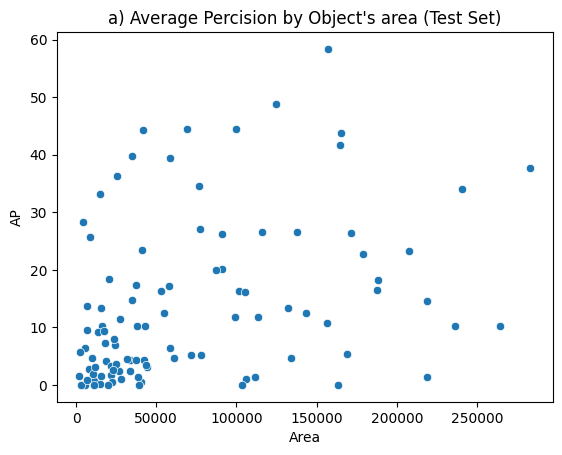

In [67]:
import seaborn as sns
import pandas as pd

test_object_data = [ (key, item[0], item[1]) for key, item in object_area_ap.items()]

area_ap_df = pd.DataFrame(pd.DataFrame(list(test_object_data),
               columns =['Object', 'AP', 'Area']))

ax = sns.scatterplot(data=area_ap_df, x="Area", y="AP")
ax.set(title='a) Average Percision by Object\'s area (Test Set)')


In [22]:
area_ap_df = pd.DataFrame(pd.DataFrame(list(test_object_data),
               columns =['Object', 'Average Percision', 'Object Size']))

In [31]:
area_ap_df.head()

,Object,Average Percision,Object Size
0,person,34.582935,tensor(76559.3594)
1,sky,33.995682,tensor(240566.5625)
2,building,12.514562,tensor(143178.0625)
3,truck,26.603097,tensor(115784.0156)
4,bus,58.393152,tensor(157357.8125)


In [91]:
cnt_object_data = [ (key, item) for key, item in eval_results['object_counts'].items()]

cnt_ap_df = pd.DataFrame(pd.DataFrame(list(cnt_object_data),
               columns =['Object', 'Count']))
cnt_ap_df = cnt_ap_df.sort_values(by='Count', ascending=False)

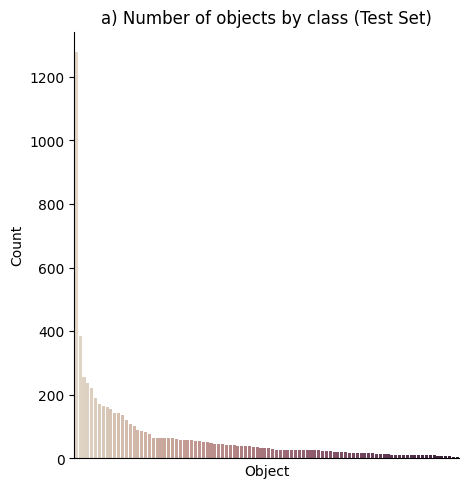

In [92]:
sns.reset_defaults()
ax= sns.catplot(x="Object", y="Count", kind="bar", palette="ch:.25",data=cnt_ap_df)
ax.set(xticklabels=[])
ax.set(xticks=[])

ax.set(title='a) Number of objects by class (Test Set)')
plt.show()

In [ ]:
sns.distplot(area_ap_df['Object Size'],bins=30,kde=False)

In [202]:
rank_ap = np.argsort([item[1] for item in test_object_data])
ranked_object = np.array([item[0] for item in test_object_data])[rank_ap]
print("Worst Performing Objects:", ranked_object[:20])

Worst Performing Objects: ['shoe' 'post' 'oven' 'faucet' 'ball' 'cart' 'computer' 'camera' 'box'
 'shelf' 'hand' 'face' 'cabinet' 'paper' 'road' 'basket' 'ramp' 'vase'
 'watch' 'traffic light']


##### Object detector performance for Train Dataset

In [81]:
eval_results = inference_on_dataset(
    model.detectron,
    train_dataloader,
    DatasetEvaluators([COCOEvaluator('vrd_train', output_dir="../generated/coco_evaluations_train/"), Counter()]))

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.843
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.

In [82]:
object_area_ap = beatify_detectron2_results(eval_results)

Evaluation results for bbox
|                 AP	->	65.29   ||               AP50	->	84.33   |
|               AP75	->	77.14   ||                APs	->	42.54   |
|                APm	->	61.40   ||                APl	->	68.77   |
Evaluation results by object category

|          AP-person	->	72.37( 71984.69 area )	||             AP-sky	->	63.33( 251812.36 area )	|
|        AP-building	->	70.92( 139850.50 area )	||           AP-truck	->	75.91( 115676.97 area )	|
|             AP-bus	->	83.10( 126690.67 area )	||           AP-table	->	73.73( 155999.31 area )	|
|           AP-shirt	->	69.00( 34707.58 area )	||           AP-chair	->	73.86( 49569.39 area )	|
|             AP-car	->	76.27( 33861.08 area )	||           AP-train	->	80.86( 185003.98 area )	|
|         AP-glasses	->	61.50( 7179.47 area )	||            AP-tree	->	67.34( 84326.91 area )	|
|            AP-boat	->	76.68( 80755.25 area )	||             AP-hat	->	67.04( 7132.03 area )	|
|           AP-trees	->	54.56( 162260.86 area )	|

[Text(0.5, 1.0, "b) Average Percision by Object's area (Train Set)")]

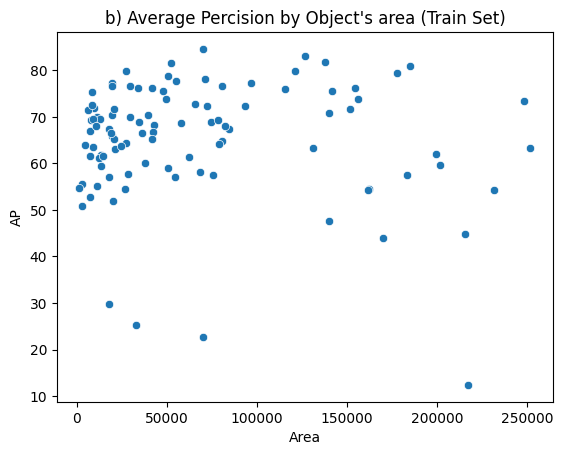

In [83]:
import seaborn as sns
import pandas as pd

train_object_data = [ (key, item[0], item[1]) for key, item in object_area_ap.items()]

area_ap_df = pd.DataFrame(pd.DataFrame(list(train_object_data),
               columns =['Object', 'AP', 'Area']))

ax = sns.scatterplot(data=area_ap_df, x="Area", y="AP")
ax.set(title='b) Average Percision by Object\'s area (Train Set)')



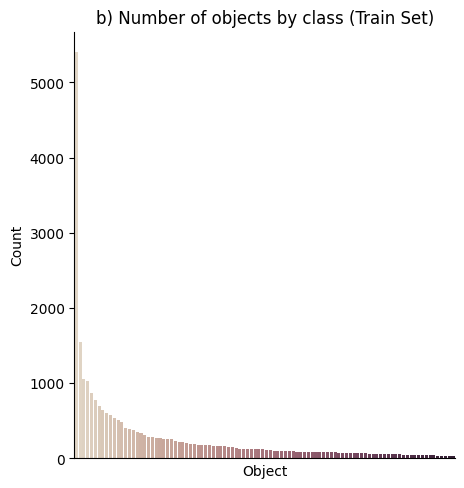

In [88]:
cnt_object_data = [ (key, item) for key, item in eval_results['object_counts'].items()]

cnt_ap_df = pd.DataFrame(pd.DataFrame(list(cnt_object_data),
               columns =['Object', 'Count']))
cnt_ap_df = cnt_ap_df.sort_values(by="Count", ascending=False)
ax= sns.catplot(x="Object", y="Count", kind="bar", palette="ch:.25",data=cnt_ap_df)
ax.set(xticklabels=[])
ax.set(xticks=[])

ax.set(title='b) Number of objects by class (Train Set)')
plt.show()

In [19]:
rank_ap = np.argsort([item[1] for item in train_object_data])
ranked_object = np.array([item[0] for item in train_object_data])[rank_ap]
print("Worst Performing Objects:", ranked_object[:20])

Worst Performing Objects: ['road' 'computer' 'coat' 'face' 'airplane' 'street' 'mountain' 'shoe'
 'post' 'camera' 'sand' 'plane' 'trees' 'jeans' 'watch' 'cone'
 'sunglasses' 'hand' 'luggage' 'ramp']


### [Optional] Test

In [12]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,    
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()

# DEPRECARTED: Old Dataloader Code
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
# cfg.DATASETS.TRAIN = ("vrd_val", )
# test_dataloader = build_detection_train_loader(cfg,
#     mapper=DatasetMapper(cfg, is_train=True, augmentations=[
#         T.Resize((800, 800))
#     ])
# )

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6

In [13]:
model = RelTransR(cfg)
device = torch.device("cuda")
model.to(device)

#Run only once
model.eval()

#Load Model
chkpoint_path = '../checkpoint/'
model_name = 'vrd2_model_transr_23000.pt'
chkpoint_full_path = os.path.join(chkpoint_path, model_name)
it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Get triples that are in the training set
import os, json

trained_triples_path = '../generated/trained_triples.json'
trained_triples = {}
if (os.path.exists(trained_triples_path)):
    with open(trained_triples_path, 'r') as file:
        trained_triples = json.load(file)
else:
    iter_dataloader = iter(train_dataloader)
    n_iters = len(train_dataloader.dataset.dataset)
    for i in range(n_iters):
        print(i)
        data = next(iter_dataloader)[0]
        relationships = data['relationships']
        for j in range(len(relationships['subj_classes'])):
            subj_cls = model.object_classes[relationships['subj_classes'][j]]
            pred_cls = model.predicate_classes[relationships['pred_classes'][j]]
            obj_cls = model.object_classes[relationships['obj_classes'][j]]
            trained_triples['{}-{}-{}'.format(subj_cls, pred_cls, obj_cls)] = 1

    with open(trained_triples_path, 'w') as file:
        file.write(json.dumps(trained_triples))

#### EVAL 1/ RELATIONSHIP PREDICTION TASK (NO GROUND TRUTH LABELS)

In [15]:
import collections
import torch

eval_config = [
    'triple_dist', #multiply subj_dist, pred_dist, obj_dist
    'pred_dist', #only pred_dist
    'pred_subtract_dist', # multiply pred_dist with subtract_dist
    'pred_transe_dist', # multiply pred_dist with transe_dist
    'triple_subtract_dist', #multiply triple_dist with subtract_dist
    'triple_transe_dist', #multiply triple_dist with transe_dist
]

def get_top_nre_relationships(data, nre=50, config='triple_dist'):
    """
        Get the top 50 or 100 relationships for a given input data (image)
        Input:
            data (Dictionary): input dictionary to the model
            nre (Integer): select top n scored relationships
            use_detector_score (Boolean): use the detectron2 detector score
            config (String Selection): see eval_config above
        Return:
            top_n_relationships (Dictionary): top nre relationships based on the `config` scoring metric
    """
    if (config not in eval_config):
        print("Error: ensure that the distance metric is one of the following options: ", eval_config)
    
    relationships = data['relationships']
    predicate_distances, subject_distances, object_distances, predicate_subtract_distances, transe_distances = model.get_predicate_distances(data, is_rel_eval=True)
    all_possible_relationships = collections.defaultdict(list) # {scores: [], subj_classes:[], pred_classes:[], obj_classes:[], subj_bboxes:[], obj_bboxes:[]}
    top_n_relationships = collections.defaultdict(list) # 

    # Iterate through the possible relationships
    for j, (pred_dists, subj_dists, obj_dists) in enumerate(zip(predicate_distances, subject_distances, object_distances)):

        #labels for subject and object
        subj_class = relationships["subj_classes"][j]
        obj_class = relationships["obj_classes"][j]
        subj_bbox = relationships["subj_bboxes"][j]
        obj_bbox = relationships["obj_bboxes"][j]
        subj_detection_score = relationships["subj_scores"][j]
        obj_detection_score = relationships["obj_scores"][j]
        
        #multiply pred, subj, obj
        #Compute scores for the 71 possible predicate and compute the score
        scoring_distances = []
        if (config == 'triple_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu() for item_pred, item_subj, item_obj in zip(pred_dists, subj_dists, obj_dists)]
        elif (config == 'pred_dist'):
            scoring_distances = [item_pred.cpu() for item_pred in pred_dists]
        elif (config == 'pred_subtract_dist'):
            scoring_distances = [item_pred.cpu()*item_subtract.cpu() for item_pred, item_subtract in zip(pred_dists, predicate_subtract_distances[j])]
        elif (config == 'pred_transe_dist'):
            scoring_distances = [item_pred.cpu()*item_transe.cpu() for item_pred, item_transe in zip(pred_dists, transe_distances[j])]
        elif (config == 'triple_subtract_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu()*item_subtract.cpu() for item_pred, item_subj, item_obj, item_subtract in zip(pred_dists, subj_dists, obj_dists, predicate_subtract_distances[j])]
        elif (config == 'triple_transe_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu()*item_transe.cpu() for item_pred, item_subj, item_obj, item_transe in zip(pred_dists, subj_dists, obj_dists, transe_distances[j])]
            
        #Adding to all_possible_relationships to rank
        for ind, distance_score in enumerate(scoring_distances):
            all_possible_relationships["subj_classes"].append(subj_class.cpu())
            all_possible_relationships["pred_classes"].append(ind)
            all_possible_relationships["obj_classes"].append(obj_class.cpu())
            all_possible_relationships["subj_bboxes"].append(subj_bbox)
            all_possible_relationships["obj_bboxes"].append(obj_bbox)
            all_possible_relationships["distance_scores"].append(distance_score)
            all_possible_relationships["subj_detection_scores"].append(subj_detection_score.detach().cpu().numpy())
            all_possible_relationships["obj_detection_scores"].append(obj_detection_score.detach().cpu().numpy())

    #rank to get the top 50, 100 relationships
    sorted_by_distance = np.argsort(all_possible_relationships["distance_scores"])
    
    for key, val in all_possible_relationships.items():
        sorted_val = np.array(val)[sorted_by_distance]
        
        top_n_relationships[key] = sorted_val
        if (nre is not None and len(val) > nre):
            top_n_relationships[key] = sorted_val[:nre]
            
    return top_n_relationships

def eval_per_image(gt_relationships, pred_relationships, gt_thr=0.5, trained_triples=None, model=None):
    """
        Iterate through the ground truth relationship of the image and check
            whether they are in the top 50 or 100, while ensuring that the IoU threshhold is above 50%
            
        Input:
            gt_relationships: ground truth relationships
            pred_relationships: top @n predicted relationships with bounding boxes, etc.
            gr_thr: IoU threshold
            trained_triples: if specified, perform zeroshot evaluation
        Return:
            tp: number of true positives
            n_gt_labels: number of ground truth labels to compute recall
    """
    n_pred_labels = len(pred_relationships["subj_bboxes"])
    n_gt_labels = len(gt_relationships["subj_bboxes"])
    n_zeroshot_gt_labels_set = set() # only used if trained_triples is specified
    visited = set() #track if ground truth has be visited
    
    tp = np.zeros((n_pred_labels,1))
    fp = np.zeros((n_pred_labels,1))
    for j in range(n_pred_labels):
        pred_triple_cls = np.array((pred_relationships["subj_classes"][j], pred_relationships["pred_classes"][j], pred_relationships["obj_classes"][j]))
        obj_bboxes = pred_relationships["obj_bboxes"][j][0]
        subj_bboxes = pred_relationships["subj_bboxes"][j][0]
        
        max_iou = gt_thr #track best overlap
        kmax = -1 #track visited

        for k in range(n_gt_labels):
            gt_triple_cls = np.array((gt_relationships["subj_classes"][k], gt_relationships["pred_classes"][k], gt_relationships["obj_classes"][k]))
            
            if (trained_triples is not None):
                gt_subj_cls = model.object_classes[gt_relationships['subj_classes'][k]]
                gt_pred_cls = model.predicate_classes[gt_relationships['pred_classes'][k]]
                gt_obj_cls = model.object_classes[gt_relationships['obj_classes'][k]]
                gt_triple_cls_label = '-'.join((gt_subj_cls, gt_pred_cls, gt_obj_cls))

                # if the label is in the training dataset, ignore
                if (gt_triple_cls_label in trained_triples):
                    continue
                    
                n_zeroshot_gt_labels_set.add(k)
                
            # Verify prediction labels match ground truth labels
            if (np.linalg.norm(gt_triple_cls - pred_triple_cls) != 0):
                continue
            # Verify that the ground truth labels has not been visited before
            if (k in visited):
                continue
            
            # Check IoU to make sure that the predicted bbox > threshold of 50%
            gt_subj_bboxes = gt_relationships["subj_bboxes"][k][0]
            gt_obj_bboxes = gt_relationships["obj_bboxes"][k][0]
            
            # Intersection between predicted bbox and gt_bbox
            subj_intersection_bbox = np.array([max(subj_bboxes[0],gt_subj_bboxes[0]),
                                                max(subj_bboxes[1],gt_subj_bboxes[1]),
                                                min(subj_bboxes[2],gt_subj_bboxes[2]),
                                                min(subj_bboxes[3],gt_subj_bboxes[3])])
            
            obj_intersection_bbox = np.array([max(obj_bboxes[0],gt_obj_bboxes[0]),
                                                max(obj_bboxes[1],gt_obj_bboxes[1]),
                                                min(obj_bboxes[2],gt_obj_bboxes[2]),
                                                min(obj_bboxes[3],gt_obj_bboxes[3])])
            
            subj_intersection_bbox_width = subj_intersection_bbox[2] - subj_intersection_bbox[0] + 1;
            subj_intersection_bbox_height = subj_intersection_bbox[3] - subj_intersection_bbox[1] + 1;

            obj_intersection_bbox_width = obj_intersection_bbox[2] - obj_intersection_bbox[0] + 1;
            obj_intersection_bbox_height = obj_intersection_bbox[3] - obj_intersection_bbox[1] + 1;
                        
            # Check overlapping
            if (subj_intersection_bbox_width > 0 and subj_intersection_bbox_height > 0 and
                obj_intersection_bbox_width > 0 and obj_intersection_bbox_height > 0):
                
                # [subject] compute overlap as area of intersection / area of union
                subj_intersection_area = subj_intersection_bbox_width * subj_intersection_bbox_height
                subj_union_area = (subj_bboxes[2] - subj_bboxes[0] + 1) * (subj_bboxes[3] - subj_bboxes[1] + 1) + \
                                (gt_subj_bboxes[2] - gt_subj_bboxes[0] + 1) * (gt_subj_bboxes[3] - gt_subj_bboxes[1] + 1) - subj_intersection_area
                subj_iou = subj_intersection_area / subj_union_area

                # [object] compute overlap as area of intersection / area of union
                obj_intersection_area = obj_intersection_bbox_width * obj_intersection_bbox_height
                obj_union_area = (obj_bboxes[2] - obj_bboxes[0] + 1) * (obj_bboxes[3] - obj_bboxes[1] + 1) + \
                                (gt_obj_bboxes[2] - gt_obj_bboxes[0] + 1) * (gt_obj_bboxes[3] - gt_obj_bboxes[1] + 1) - obj_intersection_area
                obj_iou = obj_intersection_area / obj_union_area

                 
                # only need to evaluate the minimum overlap ratio to test against the threshold
                min_iou = min(subj_iou, obj_iou)

                # makes sure that this object is detected according
                # to its individual threshold
                if (min_iou >= max_iou):
                    max_iou = min_iou;
                    kmax = k;
            
        if (kmax > -1):
            visited.add(kmax)
            tp[j] = 1
        else:
            fp[j] = 1;

    if (trained_triples is not None):
        return tp.sum(), len(n_zeroshot_gt_labels_set)
            
    return tp.sum(), n_gt_labels


def eval_dataset(dataloader, model, nre=50, config='triple_dist', trained_triples=None):
    total_true_positive = 0
    total_relationships = 0

    cumulative_recall = []
    recall = 0
    
    n_examples = len(dataloader.dataset)
    test_data_iter = iter(dataloader)
    for i in range(n_examples):
        data = next(test_data_iter)[0]
        gt_relationships = data["relationships"].copy()
        relationships = None
        top_predicted_relationships = {}

        if (len(gt_relationships['subj_bboxes']) == 0):
            #no relationship annotations for the given image
            continue

        with torch.no_grad():
            #get predicted relationships from the object detector
            relationships = model.get_predicted_relationships(data)
            data['relationships'] = relationships

        if (len(relationships['subj_bboxes']) == 0):
            #no relationship annotations for the given image
            continue

        if (i % 20 == 0 and i > 0):
            recall =  total_true_positive / total_relationships * 100
            cumulative_recall.append(recall)
            print("|----------------------Iter {}------------------------|".format(i))
            print("| TOP {} |               Recall {:5.2f}               |".format(nre, recall))

        # Get the top 
        top_predicted_relationships = get_top_nre_relationships(data, nre, config=config)
        image_true_positive, image_relationships = eval_per_image(gt_relationships, top_predicted_relationships, 0.5, trained_triples, model)
        
        total_true_positive += image_true_positive
        total_relationships += image_relationships

    recall =  total_true_positive / total_relationships * 100
    print("|----------------------Iter {}------------------------|".format(i))
    print("| TOP {} |               Recall {:5.2f}               |".format(nre, recall))
    cumulative_recall.append(recall)
    
    return cumulative_recall

##### Test Data Evaluation

In [ ]:
#test dataset
cfg.DATASETS.TEST = ("vrd_val", )

test_dataset = DatasetCatalog.get("vrd_val")
test_dataloader = build_detection_test_loader(dataset=test_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)



In [18]:
n_examples = len(test_dataloader.dataset)
test_data_iter = iter(test_dataloader)
recall_results = {}
for is_zeroshot in [True, False]:
    for nre in [50, 100]:
        for conf in eval_config:
            test_dataloader = build_detection_train_loader(cfg,
                mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                    T.Resize((800, 800))
                ])
            )
            test_data_iter = iter(test_dataloader)
            with torch.no_grad():
                if (is_zeroshot):
                    print(('is_zeroshot', nre, conf))
                    recall_results[('is_zeroshot', nre, conf)] = eval_dataset(test_data_iter, model, nre=50, config=conf, trained_triples=trained_triples)
                else:
                    print(('not_zeroshot', nre, conf))
                    recall_results[('not_zeroshot',nre, conf)] = eval_dataset(test_data_iter, model, nre=50, config=conf, trained_triples=None)

            test_dataloader = None
            del test_dataloader
            del test_data_iter
            

('is_zeroshot', 50, 'pred_dist')


/tmp/ipykernel_189080/134011521.py:74: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sorted_val = np.array(val)[sorted_by_distance]
/tmp/ipykernel_189080/134011521.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_val = np.array(val)[sorted_by_distance]


|----------------------Iter 60------------------------|
| TOP 50 |               Recall  3.85               |
|----------------------Iter 80------------------------|
| TOP 50 |               Recall  2.44               |
|----------------------Iter 100------------------------|
| TOP 50 |               Recall  2.06               |
|----------------------Iter 140------------------------|
| TOP 50 |               Recall  2.05               |
|----------------------Iter 180------------------------|
| TOP 50 |               Recall  1.82               |
|----------------------Iter 200------------------------|
| TOP 50 |               Recall  1.68               |
|----------------------Iter 220------------------------|
| TOP 50 |               Recall  2.03               |
|----------------------Iter 240------------------------|
| TOP 50 |               Recall  1.91               |
|----------------------Iter 280------------------------|
| TOP 50 |               Recall  1.65               |
|--

|----------------------Iter 980------------------------|
| TOP 50 |               Recall  1.64               |
|----------------------Iter 999------------------------|
| TOP 50 |               Recall  1.61               |
('is_zeroshot', 50, 'pred_transe_dist')
|----------------------Iter 20------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 40------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 80------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 100------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 120------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 140------------------------|
| TOP 50 |               Recall  0.00               |
|----------------------Iter 160------------------------|
| TOP 50 |        

|----------------------Iter 80------------------------|
| TOP 50 |               Recall  3.45               |
|----------------------Iter 100------------------------|
| TOP 50 |               Recall  2.67               |
|----------------------Iter 120------------------------|
| TOP 50 |               Recall  2.08               |
|----------------------Iter 200------------------------|
| TOP 50 |               Recall  1.90               |
|----------------------Iter 220------------------------|
| TOP 50 |               Recall  1.70               |
|----------------------Iter 300------------------------|
| TOP 50 |               Recall  1.73               |
|----------------------Iter 340------------------------|
| TOP 50 |               Recall  1.53               |
|----------------------Iter 360------------------------|
| TOP 50 |               Recall  1.35               |
|----------------------Iter 380------------------------|
| TOP 50 |               Recall  1.30               |
|-

|----------------------Iter 120------------------------|
| TOP 50 |               Recall  2.27               |
|----------------------Iter 140------------------------|
| TOP 50 |               Recall  1.80               |
|----------------------Iter 180------------------------|
| TOP 50 |               Recall  1.37               |
|----------------------Iter 220------------------------|
| TOP 50 |               Recall  1.15               |
|----------------------Iter 240------------------------|
| TOP 50 |               Recall  1.04               |
|----------------------Iter 280------------------------|
| TOP 50 |               Recall  1.19               |
|----------------------Iter 300------------------------|
| TOP 50 |               Recall  1.12               |
|----------------------Iter 340------------------------|
| TOP 50 |               Recall  1.01               |
|----------------------Iter 360------------------------|
| TOP 50 |               Recall  1.61               |
|

|----------------------Iter 60------------------------|
| TOP 50 |               Recall  3.33               |
|----------------------Iter 80------------------------|
| TOP 50 |               Recall  2.56               |
|----------------------Iter 100------------------------|
| TOP 50 |               Recall  3.23               |
|----------------------Iter 120------------------------|
| TOP 50 |               Recall  2.38               |
|----------------------Iter 180------------------------|
| TOP 50 |               Recall  1.61               |
|----------------------Iter 200------------------------|
| TOP 50 |               Recall  1.39               |
|----------------------Iter 240------------------------|
| TOP 50 |               Recall  1.14               |
|----------------------Iter 260------------------------|
| TOP 50 |               Recall  1.50               |
|----------------------Iter 280------------------------|
| TOP 50 |               Recall  1.33               |
|--

|----------------------Iter 940------------------------|
| TOP 50 |               Recall  1.87               |
|----------------------Iter 960------------------------|
| TOP 50 |               Recall  1.82               |
|----------------------Iter 980------------------------|
| TOP 50 |               Recall  1.79               |
|----------------------Iter 999------------------------|
| TOP 50 |               Recall  1.74               |


In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
cfg.DATASETS.TRAIN = ("vrd_val", )
del test_dataloader
del test_data_iter
test_dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)
test_data_iter = iter(test_dataloader)

In [ ]:
recall_results_path = '../generated/results_recall_vrd2_model_transr_23000.json'

with open(recall_results_path, 'w') as file:
    file.write(json.dumps(recall_results))

##### Train Data Evaluation

In [17]:
#train dataset
cfg.DATASETS.TEST = ("vrd_train", )

train_dataset = DatasetCatalog.get("vrd_train")
train_dataloader = build_detection_test_loader(dataset=train_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [18]:
recall_results = {}
for is_zeroshot in [False, True]:
    for nre in [50, 100]:
        for conf in eval_config:
            train_dataloader = build_detection_test_loader(dataset=train_dataset,
                mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                    T.Resize((800, 800))
                ])
            )
            with torch.no_grad():
                if (is_zeroshot):
                    print(('is_zeroshot', nre, conf))
                    recall_results[('is_zeroshot', nre, conf)] = eval_dataset(train_dataloader, model, nre=50, config=conf, trained_triples=trained_triples)
                else:
                    print(('not_zeroshot', nre, conf))
                    recall_results[('not_zeroshot',nre, conf)] = eval_dataset(train_dataloader, model, nre=50, config=conf, trained_triples=None)

            train_data_iter = None
            del train_dataloader
            

('not_zeroshot', 50, 'triple_dist')


/tmp/ipykernel_255143/2466572815.py:74: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sorted_val = np.array(val)[sorted_by_distance]
/tmp/ipykernel_255143/2466572815.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_val = np.array(val)[sorted_by_distance]


|----------------------Iter 40------------------------|
| TOP 50 |               Recall  9.27               |
|----------------------Iter 60------------------------|
| TOP 50 |               Recall  9.69               |
|----------------------Iter 80------------------------|
| TOP 50 |               Recall 10.04               |
|----------------------Iter 100------------------------|
| TOP 50 |               Recall 11.45               |
|----------------------Iter 120------------------------|
| TOP 50 |               Recall 11.29               |
|----------------------Iter 160------------------------|
| TOP 50 |               Recall 12.69               |
|----------------------Iter 180------------------------|
| TOP 50 |               Recall 13.08               |
|----------------------Iter 200------------------------|
| TOP 50 |               Recall 13.24               |
|----------------------Iter 220------------------------|
| TOP 50 |               Recall 13.24               |
|---

KeyboardInterrupt: 

#### EVAL 2/ PREDICATE PREDICTION TASK (GROUND TRUTH BOUNDING BOXES AND LABELS PROVIDED)

In [ ]:
import numpy as np
#Evalutation of the models performance on detective visual predicate
#default
total_true_positive = 0
total_true_positive_5 = 0
total_relationships = 0

total_true_positive_zeroshot = 0
total_true_positive_5_zeroshot = 0
total_relationships_zeroshot = 0

#sub
total_true_positive_sub = 0
total_true_positive_5_sub = 0

total_true_positive_sub_zeroshot = 0
total_true_positive_5_sub_zeroshot = 0

#mul
total_true_positive_mul = 0
total_true_positive_5_mul = 0

total_true_positive_mul_zeroshot = 0
total_true_positive_5_mul_zeroshot = 0

#transe
total_true_positive_transe = 0
total_true_positive_5_transe = 0

total_true_positive_transe_mul = 0
total_true_positive_5_transe_mul = 0

for i in range(n_examples):
    data = next(test_data_iter)[0]
    relationships = data["relationships"]
    
    if (len(relationships['subj_bboxes']) == 0):
        #no relationship annotations for the given image
        continue
    
    with torch.no_grad():
        predicate_distances, predicate_subtract_distances, transe_distances = model.get_predicate_distances(data)
        
    #Verbose
    if (i % 20 == 0 and i > 0):
        recall_zeroshot_1 = 0
        recall_zeroshot_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100

        recall_sub_1 = total_true_positive_sub / total_relationships * 100
        recall_sub_5 = total_true_positive_5_sub / total_relationships * 100
        recall_zeroshot_sub_1 = 0
        recall_zeroshot_sub_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_sub_1 = total_true_positive_sub_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_sub_5 = total_true_positive_5_sub_zeroshot / total_relationships_zeroshot * 100        
        
        recall_mul_1 = total_true_positive_mul / total_relationships * 100
        recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
        recall_zeroshot_mul_1 = 0
        recall_zeroshot_mul_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
        
        recall_transe_1 = total_true_positive_transe / total_relationships * 100
        recall_transe_5 = total_true_positive_5_transe / total_relationships * 100
        
        recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
        recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100
        
        recall_1 =  total_true_positive / total_relationships * 100
        recall_5 = total_true_positive_5 / total_relationships * 100
        print("|----------------------Iter {}------------------------|".format(i))
        print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
        print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
        print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
        print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
        print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
        print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
        print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
        print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))

    #select top 5 to calculate recall
    
    for j, pred_distance in enumerate(predicate_distances):
        sorted_pred_distance = np.argsort([item.cpu() for item in pred_distance])
        
        top_5_pred = sorted_pred_distance[:5]
        top_1_pred = sorted_pred_distance[0]
        
        #subtract
        sorted_pred_subtract_distance = np.argsort([item.cpu() for item in predicate_subtract_distances[j]])
        top_5_pred_sub = sorted_pred_subtract_distance[:5]
        top_1_pred_sub = sorted_pred_subtract_distance[0]
        
        #transe
        sorted_transe_distances = np.argsort([item.cpu() for item in transe_distances[j]])
        top_5_vtranse = sorted_transe_distances[:5]
        top_1_vtranse = sorted_transe_distances[0]

        #pred * transe
        pred_transe_multiply_distances = [ item1.cpu() * item2.cpu() for item1,item2 in zip(pred_distance, transe_distances[j])]
        top_5_pred_transe = np.argsort(pred_transe_multiply_distances[j].cpu())[:5]
        top_1_pred_transe = np.argsort(pred_transe_multiply_distances[j].cpu())[0]
        
        #pred * sub
        pred_multiply_distances = [ item1.cpu() * item2.cpu() for item1,item2 in zip(pred_distance, predicate_subtract_distances[j])]
        top_5_pred_mul = np.argsort(pred_multiply_distances)[:5]
        top_1_pred_mul = np.argsort(pred_multiply_distances)[0]

        gt_subj = model.object_classes[relationships['subj_classes'][j]]
        gt_pred = model.predicate_classes[relationships['pred_classes'][j]]
        gt_obj = model.object_classes[relationships['obj_classes'][j]]
            
        #compute true positive
        if (top_1_pred == relationships['pred_classes'][j]):
            total_true_positive += 1
        if (relationships['pred_classes'][j] in top_5_pred):
            total_true_positive_5 += 1
        
        if ('{}-{}-{}'.format(gt_subj, gt_pred, gt_obj) not in trained_triples):
            
            #default pred
            if (top_1_pred == relationships['pred_classes'][j]):
                total_true_positive_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred):
                total_true_positive_5_zeroshot += 1
                
            #sub
            if (top_1_pred_sub == relationships['pred_classes'][j]):
                total_true_positive_sub_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred_sub):
                total_true_positive_5_sub_zeroshot += 1
                
            #mul (pred*sub)
            if (top_1_pred_mul == relationships['pred_classes'][j]):
                total_true_positive_mul_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred_mul):
                total_true_positive_5_mul_zeroshot += 1
                
            total_relationships_zeroshot += 1
        
        #sub
        if (top_1_pred_sub == relationships['pred_classes'][j]):
            total_true_positive_sub += 1
        if (relationships['pred_classes'][j] in top_5_pred_sub):
            total_true_positive_5_sub += 1
        
        #pred * sub
        if (top_1_pred_mul == relationships['pred_classes'][j]):
            total_true_positive_mul += 1
        if (relationships['pred_classes'][j] in top_5_pred_mul):
            total_true_positive_5_mul += 1

        #transe
        if (top_1_vtranse == relationships['pred_classes'][j]):
            total_true_positive_transe += 1
        if (relationships['pred_classes'][j] in top_5_vtranse):
            total_true_positive_5_transe += 1
        
        #pred * sub
        if (top_1_pred_transe == relationships['pred_classes'][j]):
            total_true_positive_transe_mul += 1
        if (relationships['pred_classes'][j] in top_5_pred_transe):
            total_true_positive_5_transe_mul += 1
            
    total_relationships += len(predicate_distances)

print("Final recall top 1: ", total_true_positive / total_relationships * 100)
print("Final recall top 5: ", total_true_positive_5 / total_relationships * 100)


In [ ]:
recall_zeroshot_1 = 0
recall_zeroshot_5 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100

recall_sub_1 = total_true_positive_sub / total_relationships * 100
recall_sub_5 = total_true_positive_5_sub / total_relationships * 100
recall_zeroshot_sub_1 = 0
recall_zeroshot_sub_5 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_sub_1 = total_true_positive_sub_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_sub_5 = total_true_positive_5_sub_zeroshot / total_relationships_zeroshot * 100        

recall_mul_1 = total_true_positive_mul / total_relationships * 100
recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
recall_zeroshot_mul_1 = 0
recall_zeroshot_mul_5 = 0
if (total_relationships_zeroshot > 0):
    recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
    recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100

recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))
recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        

recall_transe_1 = total_true_positive_transe / total_relationships * 100
recall_transe_5 = total_true_positive_5_transe / total_relationships * 100

recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100

recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))

In [ ]:
#Evalutation of the models performance on detective visual object (no TransE)
import numpy as np
#total
total_relationships = 0
total_relationships_zeroshot = 0

#default
total_true_positive = 0
total_true_positive_5 = 0
total_true_positive_10 = 0

total_true_positive_zeroshot = 0
total_true_positive_5_zeroshot = 0
total_true_positive_10_zeroshot = 0

#add
total_true_positive_add = 0
total_true_positive_5_add = 0
total_true_positive_10_add = 0

total_true_positive_add_zeroshot = 0
total_true_positive_5_add_zeroshot = 0
total_true_positive_10_add_zeroshot = 0

#mul
total_true_positive_mul = 0
total_true_positive_5_mul = 0
total_true_positive_10_mul = 0

total_true_positive_mul_zeroshot = 0
total_true_positive_5_mul_zeroshot = 0
total_true_positive_10_mul_zeroshot = 0

for i in range(n_examples):
    data = next(test_data_iter)[0]
    relationships = data["relationships"]
    with torch.no_grad():
        object_distances, object_add_distances = model.get_object_distances(data)
        
    #Verbose
    if (i % 20 == 0 and i > 0):
        recall_1 =  total_true_positive / total_relationships * 100
        recall_5 = total_true_positive_5 / total_relationships * 100
        recall_10 = total_true_positive_10 / total_relationships * 100
        recall_zeroshot_1 = 0
        recall_zeroshot_5 = 0
        recall_zeroshot_10 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_10 = total_true_positive_10_zeroshot / total_relationships_zeroshot * 100

        recall_add_1 = total_true_positive_add / total_relationships * 100
        recall_add_5 = total_true_positive_5_add / total_relationships * 100
        recall_add_10 = total_true_positive_10_add / total_relationships * 100
        recall_zeroshot_add_1 = 0
        recall_zeroshot_add_5 = 0
        recall_zeroshot_add_10 = 0        
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_add_1 = total_true_positive_add_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_add_5 = total_true_positive_5_add_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_add_10 = total_true_positive_10_add_zeroshot / total_relationships_zeroshot * 100
        
        recall_mul_1 = total_true_positive_mul / total_relationships * 100
        recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
        recall_mul_10 = total_true_positive_10_mul / total_relationships * 100
        recall_zeroshot_mul_1 = 0
        recall_zeroshot_mul_5 = 0
        recall_zeroshot_mul_10 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
            recall_zeroshot_mul_10 = total_true_positive_10_mul_zeroshot / total_relationships_zeroshot * 100        
        
        print("|----------------------Iter {}------------------------|".format(i))
        print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
        print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
        print("| Recall top 10 {:5.2f} | Recall zeroshot top 10 {:5.2f} |".format(recall_10, recall_zeroshot_10))
        print("| Recall add top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_add_1, recall_zeroshot_add_1))
        print("| Recall add top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_add_5, recall_zeroshot_add_5))
        print("| Recall add top 10 {:5.2f} | Recall zeroshot sub top 10 {:5.2f} |".format(recall_add_10, recall_zeroshot_add_10))
        print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
        print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
        print("| Recall mul top 10 {:5.2f} | Recall zeroshot mul top 10 {:5.2f} |".format(recall_mul_10, recall_zeroshot_mul_10))        

    #select top 5 to calculate recall
    for j, obj_distance in enumerate(object_distances):
        top_1_obj = np.argsort(obj_distance)[0]
        top_5_obj = np.argsort(obj_distance)[:5]
        top_10_obj = np.argsort(obj_distance)[:10]
        
        #add
        top_1_obj_add = np.argsort(object_add_distances[j])[0]
        top_5_obj_add = np.argsort(object_add_distances[j])[:5]
        top_10_obj_add = np.argsort(object_add_distances[j])[:10]
        
        #pred * add
        obj_multiply_distances = [ item1 * item2 for item1,item2 in zip(obj_distance, object_add_distances[j])]
        top_1_obj_mul = np.argsort(obj_multiply_distances)[0]
        top_5_obj_mul = np.argsort(obj_multiply_distances)[:5]
        top_10_obj_mul = np.argsort(obj_multiply_distances)[:10]

        gt_subj = model.object_classes[relationships['subj_classes'][j]]
        gt_pred = model.predicate_classes[relationships['pred_classes'][j]]
        gt_obj = model.object_classes[relationships['obj_classes'][j]]
            
        #compute true positive        
        if ('{}-{}-{}'.format(gt_subj, gt_pred, gt_obj) not in trained_triples):
            
            #default pred
            if (top_1_obj == relationships['obj_classes'][j]):
                total_true_positive_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj):
                total_true_positive_5_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj):
                total_true_positive_10_zeroshot += 1

            #sub
            if (top_1_obj_add == relationships['obj_classes'][j]):
                total_true_positive_add_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj_add):
                total_true_positive_5_add_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj_add):
                total_true_positive_10_add_zeroshot += 1
                
            #mul (pred*sub)
            if (top_1_obj_mul == relationships['obj_classes'][j]):
                total_true_positive_mul_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj_mul):
                total_true_positive_5_mul_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj_mul):
                total_true_positive_10_mul_zeroshot += 1
                
            total_relationships_zeroshot += 1
        
        #normal
        if (top_1_obj == relationships['obj_classes'][j]):
            total_true_positive += 1
        if (relationships['obj_classes'][j] in top_5_obj):
            total_true_positive_5 += 1
        if (relationships['obj_classes'][j] in top_10_obj):
            total_true_positive_10 += 1
            
        #add
        if (top_1_obj_add == relationships['obj_classes'][j]):
            total_true_positive_add += 1
        if (relationships['obj_classes'][j] in top_5_obj_add):
            total_true_positive_5_add += 1
        if (relationships['obj_classes'][j] in top_10_obj_add):
            total_true_positive_10_add += 1
        
        #pred * add
        if (top_1_obj_mul == relationships['obj_classes'][j]):
            total_true_positive_mul += 1
        if (relationships['obj_classes'][j] in top_5_obj_mul):
            total_true_positive_5_mul += 1
        if (relationships['obj_classes'][j] in top_10_obj_mul):
            total_true_positive_10_mul += 1
    total_relationships += len(object_distances)

print("Final recall top 1: ", total_true_positive / total_relationships * 100)
print("Final recall top 5: ", total_true_positive_5 / total_relationships * 100)

In [ ]:
recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
recall_10 = total_true_positive_10 / total_relationships * 100
recall_zeroshot_1 = 0
recall_zeroshot_5 = 0
recall_zeroshot_10 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_10 = total_true_positive_10_zeroshot / total_relationships_zeroshot * 100

recall_add_1 = total_true_positive_add / total_relationships * 100
recall_add_5 = total_true_positive_5_add / total_relationships * 100
recall_add_10 = total_true_positive_10_add / total_relationships * 100
recall_zeroshot_add_1 = 0
recall_zeroshot_add_5 = 0
recall_zeroshot_add_10 = 0        
if (total_relationships_zeroshot > 0):
    recall_zeroshot_add_1 = total_true_positive_add_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_add_5 = total_true_positive_5_add_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_add_10 = total_true_positive_10_add_zeroshot / total_relationships_zeroshot * 100

recall_mul_1 = total_true_positive_mul / total_relationships * 100
recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
recall_mul_10 = total_true_positive_10_mul / total_relationships * 100
recall_zeroshot_mul_1 = 0
recall_zeroshot_mul_5 = 0
recall_zeroshot_mul_10 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
    recall_zeroshot_mul_10 = total_true_positive_10_mul_zeroshot / total_relationships_zeroshot * 100        

print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall top 10 {:5.2f} | Recall zeroshot top 10 {:5.2f} |".format(recall_10, recall_zeroshot_10))
print("| Recall add top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_add_1, recall_zeroshot_add_1))
print("| Recall add top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_add_5, recall_zeroshot_add_5))
print("| Recall add top 10 {:5.2f} | Recall zeroshot sub top 10 {:5.2f} |".format(recall_add_10, recall_zeroshot_add_10))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall mul top 10 {:5.2f} | Recall zeroshot mul top 10 {:5.2f} |".format(recall_mul_10, recall_zeroshot_mul_10))        


In [ ]:
data_iter = iter(train_dataloader)
data = next(data_iter)[0]
# model = RelTransR(cfg)
# negative_examples = model.generate_negative_examples(data)
# results = model(data,negative_examples)

### Training Scripts

In [ ]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .7
batch_size = 1

# Dataloaders
if ('test_dataloader' in vars()):
    del test_dataloader

train_dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)


In [122]:
train_dataset = DatasetCatalog.get("vrd_train")
train_dataloader = build_detection_train_loader(cfg,dataset=train_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [126]:
train_dataloader.dataset.dataset.dataset[0]

{'file_name': '../data/vrd/train_images/000000002658.jpg',
 'image_id': 2658,
 'relationships': {'subj_bboxes': [array([[306, 141, 590, 262]]),
   array([[306, 141, 590, 262]]),
   array([[539, 397, 680, 595]]),
   array([[539, 397, 680, 595]]),
   array([[425, 409, 556, 591]]),
   array([[425, 409, 556, 591]]),
   array([[302, 405, 420, 594]]),
   array([[159, 408, 293, 601]]),
   array([[ 47, 406, 156, 610]]),
   array([[324, 504, 458, 733]])],
  'obj_bboxes': [array([[324, 504, 458, 733]]),
   array([[324, 504, 458, 733]]),
   array([[306, 141, 590, 262]]),
   array([[425, 409, 556, 591]]),
   array([[302, 405, 420, 594]]),
   array([[306, 141, 590, 262]]),
   array([[159, 408, 293, 601]]),
   array([[ 47, 406, 156, 610]]),
   array([[159, 408, 293, 601]]),
   array([[306, 141, 590, 262]])],
  'union_bboxes': [array([306, 141, 590, 733]),
   array([306, 141, 590, 733]),
   array([306, 141, 680, 595]),
   array([425, 397, 680, 595]),
   array([302, 405, 556, 594]),
   array([306, 141

In [ ]:
import torch
import wandb
from torch.optim.lr_scheduler import StepLR
torch.manual_seed(0)

#params
n_datapoints = len(train_dataloader.dataset.dataset)
# n_datapoints = 3780
n_iters = cfg.SOLVER.MAX_ITER
num_epochs = int(n_iters / n_datapoints)
chkpoint_it = n_datapoints #create a checkpoint every 1000 iterations

#model
model = RelTransR(cfg)
device = torch.device("cuda")
model.to(device)

#scheduler
learning_rate = 0.001
gamma = cfg.SOLVER.GAMMA
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

#wandb
log_interval = 20
wandb.init(project="vrdtransr-project3", entity="herobaby71")
wandb.config = {
    "seed": 0,
    "learning_rate": learning_rate,
    "gamma": 0.1,
    "momentum": 0.9,
    "epochs": num_epochs,
    "n_iters": n_iters,
    "batch_size": 1
}
wandb.watch(model, log="all", log_freq=20)

In [ ]:
def train_log(loss, lr, it, epoch, loss_subj, loss_pred, loss_obj, loss_transr):
    # Where the magic happens
    wandb.log({"lr":lr, "epoch": epoch, "loss": loss, "loss_subj": loss_subj, "loss_pred": loss_pred, "loss_obj": loss_obj, "loss_transr":loss_transr}, step=it)

In [ ]:
import time
import os

#checkpoint every 2000 steps
chkpoint_it = 1000

it = 0
initial_it = 0 # checkpoint intial iteration to resume training
start_time = time.time()
losses = []

#load checkpoint
load_chkpoint = False
if (load_chkpoint):
    chkpoint_path = '../checkpoint/'
    model_name = 'vrd2_model_18000.pt'
    chkpoint_full_path = os.path.join(chkpoint_path, model_name)
    it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path, optimizer=optimizer)
    initial_it = it

In [ ]:
import os, json

trained_triples_path = '../generated/trained_triples.json'
trained_triples = {}
if (os.path.exists(trained_triples_path)):
    with open(trained_triples_path) as file:
        trained_triples = json.load(trained_triples_path)
else:
    iter_dataloader = iter(train_dataloader)
    n_iters = len(train_dataloader.dataset.dataset)
    for i in range(n_iters):
        print(i)
        data = next(iter_dataloader)[0]
        relationships = data['relationships']
        for j in range(len(relationships['subj_classes'])):
            subj_cls = model.object_classes[relationships['subj_classes'][j]]
            pred_cls = model.predicate_classes[relationships['pred_classes'][j]]
            obj_cls = model.object_classes[relationships['obj_classes'][j]]
            trained_triples['{}-{}-{}'.format(subj_cls, pred_cls, obj_cls)] = 1

    with open(trained_triples_path, 'w') as file:
        file.write(json.dumps(trained_triples))

In [ ]:
iter_dataloader = iter(train_dataloader)
interval_cnt = 0

#Losses
total_loss = 0
subj_loss = 0
obj_loss = 0
pred_loss = 0
transr_loss = 0

for i in range(n_iters):
    #iterator
    try:
        data = next(iter_dataloader)[0]
    except StopIteration:
        print("iterator has reach its end at iteration {}. Initializing a new iterator.".format(str(it)))
        iter_dataloader = iter(train_dataloader)
        data = next(iter_dataloader)[0]

    #continue training from the previous checkpoint
    if (i < initial_it % n_datapoints):
        continue

    if (len(data['relationships']['subj_bboxes']) == 1):
        #image has only one relationship, cannot train
        print("an image has been removed for this batch")
        continue
        
    #other exclusion due to bad label
    if ('1841.jpg' in data["file_name"]):
        print("this image has bad label and has been removed.")
        continue

    optimizer.zero_grad()

    #forward passes
    negative_examples = {}
    negative_examples = model.generate_negative_examples(data)
#     print("number of objects:", len( data['instances'].get_fields()['gt_boxes']))
#     print("number of neg examples:", len(negative_examples))
    triplet_losses = model(data, negative_examples)
    
    #compute gradient backward
    final_loss = triplet_losses['obj'] + triplet_losses['pred'] + triplet_losses['subj'] + triplet_losses['transr']
    final_loss.backward()
    optimizer.step()

    #total loss
    total_loss += final_loss.item()
    subj_loss += triplet_losses['subj'].item()
    pred_loss += triplet_losses['pred'].item()
    obj_loss += triplet_losses['obj'].item()
    transr_loss += triplet_losses['transr'].item()
    
    interval_cnt += 1
    if (it > initial_it and it % log_interval == 0 and it > 0):
        current_loss = total_loss / interval_cnt
        losses.append(current_loss)
        elapsed = time.time() - start_time
        epoch = it / n_datapoints
        print('| it {} | epoch {} | lr {} | ms/batch {:5.2f} | loss {:5.2f}'.format(
            it, int(epoch), scheduler.get_last_lr()[0], elapsed * 1000 / log_interval, current_loss))
        train_log(current_loss, scheduler.get_last_lr()[0], it, int(epoch),
                  loss_subj=subj_loss/interval_cnt, loss_pred=pred_loss/interval_cnt,
                  loss_obj=obj_loss/interval_cnt, loss_transr=transr_loss/interval_cnt)
        total_loss = 0
        subj_loss = 0
        pred_loss = 0
        obj_loss = 0
        transr_loss = 0
        interval_cnt = 0
        start_time = time.time()

    if (it > initial_it and it % chkpoint_it == 0 and it > 0):
        chkpnt = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "it": it,
            "losses": losses
        }
        torch.save(chkpnt, os.path.join(chkpoint_path, 'vrd2_model_transr_{}.pt'.format(str(it))))
        
    #increment total count
    it = it + 1

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

### [Optional] Test Eval Model Performance

In [ ]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)

cfg = get_vrd_cfg()

#model
# model = RelTransR(cfg)
# device = torch.device("cuda")
# model.to(device)

#test dataloader
cfg.DATASETS.TRAIN = ("vrd_val", )
test_dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [ ]:
global_loss = 0
avg_loss = 0
cnt = 0

total_loss = 0
pred_loss = 0
interval_cnt = 0

model.eval()
test_data_iter = iter(test_dataloader)
broken_image = []

with torch.no_grad():
    for i in range(2000):
        data = next(test_data_iter)[0]

        #If there is only one relationship (not suitable to be evaluate with the given loss)
        if (len(data['relationships']['subj_bboxes']) == 1):
            #image has only one relationship, cannot train
            print("an image has been removed for this batch")
            broken_image.append(data)
            continue

        # get negative examples and compute losses
        negative_examples = model.generate_negative_examples(data)
        triplet_losses = model(data, negative_examples)
        final_loss = triplet_losses['obj'] + triplet_losses['subj'] + triplet_losses['pred']

        #output interval loss
        total_loss += final_loss.item()
        pred_loss += triplet_losses['subj'].item()
        interval_cnt += 1
        if (i > 0 and i % 20 == 0):
            current_loss = total_loss / interval_cnt
            pred_current_loss = pred_loss / interval_cnt
            print('| iter: {} | loss {:5.2f} | pred_loss {:5.2f}'.format(i, current_loss, pred_current_loss))
            total_loss = 0
            pred_loss = 0
            interval_cnt = 0

        #update global loss
        global_loss += final_loss.item()
        cnt += 1
avg_loss = total_loss / cnt

In [ ]:
global_loss/cnt

In [ ]:
avg_loss

In [ ]:
avg_loss

In [ ]:
avg_loss

In [ ]:
cnt

In [ ]:
del model
del train_dataloader
del test_dataloader
torch.cuda.empty_cache()

In [ ]:
from os import listdir
from os.path import isfile, join
chkpoint_path = '../checkpoint/'

onlyfiles = [f for f in listdir(chkpoint_path) if isfile(join(chkpoint_path, f))]
onlyfiles

In [ ]:
a= torch.tensor([1,2,3])
b= torch.tensor([45, 65, 65])

c = torch.stack([a,b])

In [ ]:
c

In [ ]:
import torch
import torch.nn.functional as F

x = torch.tensor([[1,2,3], [2,3,4]])
y = torch.tensor([[1,2,3.2]])

1- F.cosine_similarity(x, y)

In [ ]:

x = torch.tensor([[1,2,3], [2,3,4]])
y = torch.tensor([[1.5,2.25], [2.1,3.2]])

In [ ]:
x.shape

In [ ]:
torch.cat((x, y), 1)